In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.feature_selection import SelectKBest, chi2, RFE, RFECV
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict,\
train_test_split, GridSearchCV, StratifiedKFold

from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier, RUSBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import catboost as cb
import lightgbm as lgb

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve,\
roc_auc_score, confusion_matrix, precision_recall_curve, classification_report, matthews_corrcoef
import scikitplot as skplt
from pandas_ml import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

C:\Users\syami\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\syami\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
data = pd.read_csv('train_2v.csv')
test_data = pd.read_csv('test_2v.csv')

data['source'] = 'train'
test_data['source'] = 'test'
merged = pd.concat([data, test_data], ignore_index = True)
print ('Merged shape = ', merged.shape, '\n', 'Train shape = ', data.shape, '\n', 'Test shape = ', test_data.shape)

merged.head()

Merged shape =  (62001, 13) 
 Train shape =  (43400, 13) 
 Test shape =  (18601, 12)


Residence_type   age  avg_glucose_level   bmi ever_married  gender  \
0          Rural   3.0              95.12  18.0           No    Male   
1          Urban  58.0              87.96  39.2          Yes    Male   
2          Urban   8.0             110.89  17.6           No  Female   
3          Rural  70.0              69.04  35.9          Yes  Female   
4          Rural  14.0             161.28  19.1           No    Male   

   heart_disease  hypertension     id   smoking_status source  stroke  \
0              0             0  30669              NaN  train     0.0   
1              0             1  30468     never smoked  train     0.0   
2              0             0  16523              NaN  train     0.0   
3              0             0  56543  formerly smoked  train     0.0   
4              0             0  46136              NaN  train     0.0   

      work_type  
0      children  
1       Private  
2       Private  
3       Private  
4  Never_worked

In [3]:
def age_group (x):
    if x < 20.0 :
        return float (0)
    if x >= 20.0 and x <= 65.0:
        return float (1)
    else:
        return float (2)

merged['age_grp'] = merged['age'].apply(age_group)
merged.head()

Residence_type   age  avg_glucose_level   bmi ever_married  gender  \
0          Rural   3.0              95.12  18.0           No    Male   
1          Urban  58.0              87.96  39.2          Yes    Male   
2          Urban   8.0             110.89  17.6           No  Female   
3          Rural  70.0              69.04  35.9          Yes  Female   
4          Rural  14.0             161.28  19.1           No    Male   

   heart_disease  hypertension     id   smoking_status source  stroke  \
0              0             0  30669              NaN  train     0.0   
1              0             1  30468     never smoked  train     0.0   
2              0             0  16523              NaN  train     0.0   
3              0             0  56543  formerly smoked  train     0.0   
4              0             0  46136              NaN  train     0.0   

      work_type  age_grp  
0      children      0.0  
1       Private      1.0  
2       Private      0.0  
3       Private      2.0  
4  Never_worked      0.0

### <font color = blue>Imputation for Data<font>

In [4]:
merged['smoking_status'].unique()

array([nan, 'never smoked', 'formerly smoked', 'smokes'], dtype=object)

In [5]:
# Smoking status depends on gender, work type and hypertension or heart disease.
# v = smoking status
# w = age
# x = heart_disease
# y = hypertension
# z = work type

def smoking_impute (cols):
    smoking_status = cols[0]
    age = cols[1]
    heart_disease = cols[2]
    hypertension = cols[3]
    work_type = cols [4]
    
    if pd.isnull(smoking_status):
    
        if work_type == 'children' or hypertension == 0 or heart_disease == 0:
            return 'never smoked'
        elif work_type != 'Never_worked':
            if age < 55.0:
                if heart_disease == 1 or hypertension == 1:
                    return 'smokes'
                else:
                    return 'never smoked'
            elif age >= 55.0:
                if hypertension == 0:
                    return 'formerly smoked'
                else:
                    return 'never smoked'
        elif work_type == 'Never_worked':
            if heart_disease == 1 or hypertension == 1:
                    return 'smokes'
    else:
        return smoking_status

In [6]:
merged['smoking_status'] = merged[['smoking_status', 'age', 'heart_disease',\
                                   'hypertension', 'work_type']].apply(smoking_impute, axis = 1)
merged.head()

Residence_type   age  avg_glucose_level   bmi ever_married  gender  \
0          Rural   3.0              95.12  18.0           No    Male   
1          Urban  58.0              87.96  39.2          Yes    Male   
2          Urban   8.0             110.89  17.6           No  Female   
3          Rural  70.0              69.04  35.9          Yes  Female   
4          Rural  14.0             161.28  19.1           No    Male   

   heart_disease  hypertension     id   smoking_status source  stroke  \
0              0             0  30669     never smoked  train     0.0   
1              0             1  30468     never smoked  train     0.0   
2              0             0  16523     never smoked  train     0.0   
3              0             0  56543  formerly smoked  train     0.0   
4              0             0  46136     never smoked  train     0.0   

      work_type  age_grp  
0      children      0.0  
1       Private      1.0  
2       Private      0.0  
3       Private      2.0  
4  Never_worked      0.0

In [7]:
merged['smoking_status'].value_counts()

never smoked       41922
formerly smoked    10753
smokes              9326
Name: smoking_status, dtype: int64

In [8]:
merged.loc[merged['smoking_status'].isnull()]

Empty DataFrame
Columns: [Residence_type, age, avg_glucose_level, bmi, ever_married, gender, heart_disease, hypertension, id, smoking_status, source, stroke, work_type, age_grp]
Index: []

In [9]:
def bmi_impute (cols):
    bmi = cols[0]
    age = cols[1]
    gender = cols[2]
    smoking_status = cols[3]
    
    if pd.isnull(bmi):
        if age < 20.0:
            if gender == 'Female':
                if smoking_status == 'smokes':
                    return 26.852
                elif smoking_status == 'formerly smoked':
                    return 25.437
                elif smoking_status == 'never smoked':
                    return 25.211
            if gender == 'Male':
                if smoking_status == 'smokes':
                    return 25.949
                elif smoking_status == 'formerly smoked':
                    return 25.023
                elif smoking_status == 'never smoked':
                    return  25.924
            else:
                return 22.125
                
        if age >= 20.0 and age <= 65.0:
            if gender == 'Female':
                if smoking_status == 'smokes':
                    return 30.189
                elif smoking_status == 'formerly smoked':
                    return 31.325
                elif smoking_status == 'never smoked':
                    return 30.327
            if gender == 'Male':
                if smoking_status == 'smokes':
                    return 30.291
                elif smoking_status == 'formerly smoked':
                    return 31.79
                elif smoking_status == 'never smoked':
                    return 30.923
            else:
                return 30.950
        else:
            return 28.000
    else:
        return bmi

In [10]:
merged['bmi'] = merged[['bmi', 'age', 'gender',\
                                   'smoking_status']].apply(bmi_impute, axis = 1)
merged.head()

Residence_type   age  avg_glucose_level   bmi ever_married  gender  \
0          Rural   3.0              95.12  18.0           No    Male   
1          Urban  58.0              87.96  39.2          Yes    Male   
2          Urban   8.0             110.89  17.6           No  Female   
3          Rural  70.0              69.04  35.9          Yes  Female   
4          Rural  14.0             161.28  19.1           No    Male   

   heart_disease  hypertension     id   smoking_status source  stroke  \
0              0             0  30669     never smoked  train     0.0   
1              0             1  30468     never smoked  train     0.0   
2              0             0  16523     never smoked  train     0.0   
3              0             0  56543  formerly smoked  train     0.0   
4              0             0  46136     never smoked  train     0.0   

      work_type  age_grp  
0      children      0.0  
1       Private      1.0  
2       Private      0.0  
3       Private      2.0  
4  Never_worked      0.0

In [11]:
merged.loc[merged['bmi'].isnull()]

Empty DataFrame
Columns: [Residence_type, age, avg_glucose_level, bmi, ever_married, gender, heart_disease, hypertension, id, smoking_status, source, stroke, work_type, age_grp]
Index: []

In [12]:
print ('Data info: ', merged.info())
print('----------------------------')
print ('Data shape: ',  merged.shape)
print('----------------------------')
print ('Data null:\n', merged.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62001 entries, 0 to 62000
Data columns (total 14 columns):
Residence_type       62001 non-null object
age                  62001 non-null float64
avg_glucose_level    62001 non-null float64
bmi                  62001 non-null float64
ever_married         62001 non-null object
gender               62001 non-null object
heart_disease        62001 non-null int64
hypertension         62001 non-null int64
id                   62001 non-null int64
smoking_status       62001 non-null object
source               62001 non-null object
stroke               43400 non-null float64
work_type            62001 non-null object
age_grp              62001 non-null float64
dtypes: float64(5), int64(3), object(6)
memory usage: 6.6+ MB
Data info:  None
----------------------------
Data shape:  (62001, 14)
----------------------------
Data null:
 Residence_type           0
age                      0
avg_glucose_level        0
bmi                      0
ever_

#### <font color = blue>Feature Engineering<font>

In [33]:
# Diabetes group
# Take into consideration the age (for adult wise), hypertension and avg glucose level fr now.
# For age group 0, kids between 1 month old - 20 years old, use bmi.

# """
# Defining Diabetes (Type 2):

# Usually in adults the symptoms are:
# - Risk increases for those aged 45 years old and above
# - Average glucose level measured aft meal is 200mg/dL or higher (for diabetic patients, prediabetic: 140-199mg/dL)
# - Hypertension
# - Other factors that would increase the risk of getting diabetes include History of Heart disease,
#   Smoking and Lifestyle (in this case we look at work type)
  
# For adolescents and the young:
# - BMI (overweight individuals)
# - Average glucose level measured after meal is higher than 200mg/dL ()

def diabetes (y):
    if y >= 200.00:
        return float (2)
    if y > 140.00 and y < 200.00:
        return float (1)
    else:
        return float (0)

merged['diabetes'] = merged['avg_glucose_level'].apply(diabetes)
merged.head()

Residence_type   age  avg_glucose_level   bmi ever_married  gender  \
0          Rural   3.0              95.12  18.0           No    Male   
1          Urban  58.0              87.96  39.2          Yes    Male   
2          Urban   8.0             110.89  17.6           No  Female   
3          Rural  70.0              69.04  35.9          Yes  Female   
4          Rural  14.0             161.28  19.1           No    Male   

   heart_disease  hypertension     id   smoking_status source  stroke  \
0              0             0  30669     never smoked  train     0.0   
1              0             1  30468     never smoked  train     0.0   
2              0             0  16523     never smoked  train     0.0   
3              0             0  56543  formerly smoked  train     0.0   
4              0             0  46136     never smoked  train     0.0   

      work_type  age_grp  diabetes  
0      children      0.0       0.0  
1       Private      1.0       0.0  
2       Private      0.0       0.0  
3       Private      2.0       0.0  
4  Never_worked      0.0       1.0

In [34]:
# 0 = healthy eating habits
# 1 = unhealthy eating habits
# 2 = very unhealthy eating habits

# x = hypertension (wrt salt intake)
# y = avg_glucose_level (wrt to carbs and sugar intake)
# z = heart disease (wrt fatty food intake)

def eating_habits (cols):
    hypertension = cols[0]
    avg_glucose_level = cols[1]
    heart_disease = cols[2]
    
    if hypertension == 1 and avg_glucose_level >= 200.00 and heart_disease == 1:
        return float (2)
    if hypertension == 0 and avg_glucose_level <= 140.00 and heart_disease == 0:
        return float (0)
    else:
        return float (1)
    
merged['eating_habits'] = merged[['hypertension', 'avg_glucose_level', 'heart_disease']].apply(eating_habits, axis = 1)
merged.head()

Residence_type   age  avg_glucose_level   bmi ever_married  gender  \
0          Rural   3.0              95.12  18.0           No    Male   
1          Urban  58.0              87.96  39.2          Yes    Male   
2          Urban   8.0             110.89  17.6           No  Female   
3          Rural  70.0              69.04  35.9          Yes  Female   
4          Rural  14.0             161.28  19.1           No    Male   

   heart_disease  hypertension     id   smoking_status source  stroke  \
0              0             0  30669     never smoked  train     0.0   
1              0             1  30468     never smoked  train     0.0   
2              0             0  16523     never smoked  train     0.0   
3              0             0  56543  formerly smoked  train     0.0   
4              0             0  46136     never smoked  train     0.0   

      work_type  age_grp  diabetes  eating_habits  
0      children      0.0       0.0            0.0  
1       Private      1.0       0.0            1.0  
2       Private      0.0       0.0            0.0  
3       Private      2.0       0.0            0.0  
4  Never_worked      0.0       1.0            1.0

In [35]:
merged['eating_habits'].value_counts()

0.0    47723
1.0    14084
2.0      194
Name: eating_habits, dtype: int64

In [36]:
# 0 = Not a breadwinner
# 1 = Breadwinner

# x = gender (breadwinner target: male)
# y = marital status (breadwinner target: married)
# z = working (breadwinner target: govt, self-employed and private vs nvr worked individuals)

def breadwinner (cols):
    ever_married = cols[0]
    work_type = cols[1]
    
    if work_type != 'Never_worked':
        if ever_married == 'Yes':
            return float (1)
        else:
            return float (0)
    else:
        return float (0)

merged['breadwinner'] = merged[['work_type', 'ever_married']].apply(breadwinner, axis = 1)
merged.head()

Residence_type   age  avg_glucose_level   bmi ever_married  gender  \
0          Rural   3.0              95.12  18.0           No    Male   
1          Urban  58.0              87.96  39.2          Yes    Male   
2          Urban   8.0             110.89  17.6           No  Female   
3          Rural  70.0              69.04  35.9          Yes  Female   
4          Rural  14.0             161.28  19.1           No    Male   

   heart_disease  hypertension     id   smoking_status source  stroke  \
0              0             0  30669     never smoked  train     0.0   
1              0             1  30468     never smoked  train     0.0   
2              0             0  16523     never smoked  train     0.0   
3              0             0  56543  formerly smoked  train     0.0   
4              0             0  46136     never smoked  train     0.0   

      work_type  age_grp  diabetes  eating_habits  breadwinner  
0      children      0.0       0.0            0.0          0.0  
1       Private      1.0       0.0            1.0          0.0  
2       Private      0.0       0.0            0.0          0.0  
3       Private      2.0       0.0            0.0          0.0  
4  Never_worked      0.0       1.0            1.0          0.0

In [37]:
# 0 = No Smoking
# 1 = smoking
# 2 = 2ndhand smoking

# x = smoking status
# y = type of workplace

def secondhand_smoke (cols):
    smoking_status = cols[0]
    work_type = cols[1]
    
    if work_type != 'Never_worked':
        if smoking_status == 'never smoked':
            return float (1)
        else:
            return float (0)
    else:
        if smoking_status == 'never smoked':
            return float (1)
        else:
            return float (0)

merged['secondhand_smoke'] = merged[['smoking_status', 'work_type']].apply(secondhand_smoke, axis = 1)
merged.head()

Residence_type   age  avg_glucose_level   bmi ever_married  gender  \
0          Rural   3.0              95.12  18.0           No    Male   
1          Urban  58.0              87.96  39.2          Yes    Male   
2          Urban   8.0             110.89  17.6           No  Female   
3          Rural  70.0              69.04  35.9          Yes  Female   
4          Rural  14.0             161.28  19.1           No    Male   

   heart_disease  hypertension     id   smoking_status source  stroke  \
0              0             0  30669     never smoked  train     0.0   
1              0             1  30468     never smoked  train     0.0   
2              0             0  16523     never smoked  train     0.0   
3              0             0  56543  formerly smoked  train     0.0   
4              0             0  46136     never smoked  train     0.0   

      work_type  age_grp  diabetes  eating_habits  breadwinner  \
0      children      0.0       0.0            0.0          0.0   
1       Private      1.0       0.0            1.0          0.0   
2       Private      0.0       0.0            0.0          0.0   
3       Private      2.0       0.0            0.0          0.0   
4  Never_worked      0.0       1.0            1.0          0.0   

   secondhand_smoke  
0               1.0  
1               1.0  
2               1.0  
3               0.0  
4               1.0

In [38]:
# 0 = Low stroke risk
# 1 = Stroke risk

# w = age
# x = diabetes
#  heart disease
#  hypertension
# smoking

def lead_factor (cols):
    age = cols[0]
    hypertension = cols[1]
    heart_disease = cols[2]
    diabetes = cols[3]
    smoking_status = cols[4]
    
    if age >= 55.0:
        if hypertension == 1 or heart_disease == 1 or diabetes == 2 or smoking_status != 'never smoked': 
            return float (1)
        if hypertension == 1 and heart_disease == 1 or diabetes == 2 or smoking_status != 'never smoked': 
            return float (1)
        if hypertension == 1 or heart_disease == 1 and diabetes == 2 or smoking_status != 'never smoked': 
            return float (1)
        if hypertension == 1 or heart_disease == 1 or diabetes == 2 and smoking_status == 'never smoked': 
            return float (1)
        else:
            return float (0)
    else:
        if hypertension == 1 or heart_disease == 1 or diabetes == 2 and smoking_status == 'never smoked': 
            return float (1)
        else:
            return float (0)

merged['lead_factor'] = merged[['age', 'hypertension', 'heart_disease', 'diabetes',\
                                'smoking_status']].apply(lead_factor, axis = 1)
merged.head()

Residence_type   age  avg_glucose_level   bmi ever_married  gender  \
0          Rural   3.0              95.12  18.0           No    Male   
1          Urban  58.0              87.96  39.2          Yes    Male   
2          Urban   8.0             110.89  17.6           No  Female   
3          Rural  70.0              69.04  35.9          Yes  Female   
4          Rural  14.0             161.28  19.1           No    Male   

   heart_disease  hypertension     id   smoking_status source  stroke  \
0              0             0  30669     never smoked  train     0.0   
1              0             1  30468     never smoked  train     0.0   
2              0             0  16523     never smoked  train     0.0   
3              0             0  56543  formerly smoked  train     0.0   
4              0             0  46136     never smoked  train     0.0   

      work_type  age_grp  diabetes  eating_habits  breadwinner  \
0      children      0.0       0.0            0.0          0.0   
1       Private      1.0       0.0            1.0          0.0   
2       Private      0.0       0.0            0.0          0.0   
3       Private      2.0       0.0            0.0          0.0   
4  Never_worked      0.0       1.0            1.0          0.0   

   secondhand_smoke  lead_factor  
0               1.0          0.0  
1               1.0          1.0  
2               1.0          0.0  
3               0.0          1.0  
4               1.0          0.0

In [39]:
# 0 = Healthy lifestyle behavior
# 1 = Unhealthy lifestyle behavior

# age_group
# bmi
# eating_habits: 0 = healthy eating habits, 1 = unhealthy eating habits, 2 = very unhealthy eating habits
# smoking
# work_type


def lifestyle_behavior (cols):
    age_grp = cols[0]
    bmi = cols[1]
    eating_habits = cols[2]
    smoking_status = cols[3]
    work_type = cols[4]
    
    if age_grp == 1:
        if bmi <= 25.0 and eating_habits == 0 and smoking_status == 'never smoked' and work_type != 'Never_worked' : 
            return float (0)
        else:
            return float (1)
    elif age_grp == 0:
        if bmi <= 28.0 and eating_habits == 0 and smoking_status == 'never smoked' and work_type != 'Never_worked' : 
            return float (0)
        else:
            return float (1)
    else:
        if bmi <= 27.0 and eating_habits == 0 and smoking_status == 'never smoked' and work_type == 'Never_worked' : 
            return float (0)
        elif bmi <= 27.0 and eating_habits == 0 and smoking_status == 'never smoked' and work_type == 'children' : 
            return float (0)
        else:
            return float (1)
            
merged['lifestyle_behavior'] = merged[['age_grp', 'bmi', 'diabetes', 'smoking_status',\
                                      'work_type']].apply(lifestyle_behavior, axis = 1)
merged.head()

Residence_type   age  avg_glucose_level   bmi ever_married  gender  \
0          Rural   3.0              95.12  18.0           No    Male   
1          Urban  58.0              87.96  39.2          Yes    Male   
2          Urban   8.0             110.89  17.6           No  Female   
3          Rural  70.0              69.04  35.9          Yes  Female   
4          Rural  14.0             161.28  19.1           No    Male   

   heart_disease  hypertension     id   smoking_status source  stroke  \
0              0             0  30669     never smoked  train     0.0   
1              0             1  30468     never smoked  train     0.0   
2              0             0  16523     never smoked  train     0.0   
3              0             0  56543  formerly smoked  train     0.0   
4              0             0  46136     never smoked  train     0.0   

      work_type  age_grp  diabetes  eating_habits  breadwinner  \
0      children      0.0       0.0            0.0          0.0   
1       Private      1.0       0.0            1.0          0.0   
2       Private      0.0       0.0            0.0          0.0   
3       Private      2.0       0.0            0.0          0.0   
4  Never_worked      0.0       1.0            1.0          0.0   

   secondhand_smoke  lead_factor  lifestyle_behavior  
0               1.0          0.0                 0.0  
1               1.0          1.0                 1.0  
2               1.0          0.0                 0.0  
3               0.0          1.0                 1.0  
4               1.0          0.0                 1.0

In [40]:
merged.isnull().sum()

Residence_type            0
age                       0
avg_glucose_level         0
bmi                       0
ever_married              0
gender                    0
heart_disease             0
hypertension              0
id                        0
smoking_status            0
source                    0
stroke                18601
work_type                 0
age_grp                   0
diabetes                  0
eating_habits             0
breadwinner               0
secondhand_smoke          0
lead_factor               0
lifestyle_behavior        0
dtype: int64

In [41]:
# 0 = Unable to determine (smoking prefer not to be disclosed)
# 1 = No workplace smoking
# 2 = Workplace smoking

# x = smoking status
# y = type of workplace
# z = bmi

# def work_life_imbalance (x, y):
#     if (x == 'smokes' or x == 'formerly smoked') and (y == 'Private' or y == 'Self-employed' or y == 'Govt_job') and z >= 30.0:
#         return float (2)
#     if x == 'never smoked' and (y == 'Private' or y == 'Self-employed' or y == 'Govt_job' or y == 'Never_worked') and z < 30.0:
#         return float (1)
#     else:
#         return float (0)

# iidata_adult['work_life_imbalance'] = iidata_adult.apply(lambda row: work_life_imbalance(row['smoking_status'], row['work_type']), axis = 1)
# iidata_adult.head()

In [42]:
# # 0 = Low stroke risk
# # 1 = Stroke risk

# # w = age
# # x = bmi
# # y = hypertension
# # z = heart_disease

# def lead_factor (w, x, y, z):
#     if w >= 55.0 and x >= 30.0 or y == 1 or z == 1:
#         return float (1)
#     if w >= 55.0 and x >= 30.0 and y == 1 or z == 1:
#         return float (1)
#     if w >= 55.0 and x >= 30.0 or y == 1 and z == 1:
#         return float (1)
#     else:
#         return float (0)

# iidata_adult['lead_factor'] = iidata_adult.apply(lambda row: lead_factor(row['age'], row['bmi_i'], row['hypertension'], row['heart_disease']), axis = 1)
# iidata_adult.head()

In [26]:
# 0 = No ageing factors
# 1 = Ageing factors

# v = age
# w = diabetes
# x = hypertension
# y = heart_disease
# z = smoking status

# def ageing (v, w, x, y, z):
#     if v >= 65.0 and w >= 1 and x == 1 and y == 1 and (z == 'smokes' or z == 'formerly smoked'):
#         return float (1)
#     if v >= 65.0 and x == 1 and y == 1 and (z == 'smokes' or z == 'formerly smoked'):
#         return float (1)
#     if v >= 65.0 and w == 1 and y == 1 and (z == 'smokes' or z == 'formerly smoked'):
#         return float (1)
#     if v >= 65.0:
#         return float (1)
#     else:
#         return float (0)

# iidata_adult['ageing'] = iidata_adult.apply(lambda row: ageing(row['age'], row['Diabetes'], row['hypertension'], row['heart_disease'], row['smoking_status']), axis = 1)
# iidata_adult.head()

#### <font color = blue>Other Preprocessing: Get dummies and scaling numerical features (using MinMaxScaler)<font>

In [43]:
merged_copy = merged.copy()

In [44]:
training = merged[merged_copy['source'] == 'train']

In [45]:
test = merged[merged_copy['source'] == 'test']

In [46]:
print ('Training shape: ', training.shape)
print ('--------------------')
print ('Test shape: ', test.shape)

Training shape:  (43400, 20)
--------------------
Test shape:  (18601, 20)


In [47]:
training = training.drop(['source'], axis = 1)
training.shape

(43400, 19)

In [48]:
training = pd.get_dummies(training)

In [49]:
training_sc = training.copy()

cols_tbscaled = ['age', 'bmi', 'avg_glucose_level']
features = training[cols_tbscaled]
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)

training_sc[cols_tbscaled] = features
training_sc.head()

age  avg_glucose_level       bmi  heart_disease  hypertension     id  \
0  0.035645           0.169964  0.090286              0             0  30669   
1  0.707031           0.139631  0.332571              0             1  30468   
2  0.096680           0.236772  0.085714              0             0  16523   
3  0.853516           0.059479  0.294857              0             0  56543   
4  0.169922           0.450244  0.102857              0             0  46136   

   stroke  age_grp  diabetes  eating_habits         ...          gender_Male  \
0     0.0      0.0       0.0            0.0         ...                    1   
1     0.0      1.0       0.0            1.0         ...                    1   
2     0.0      0.0       0.0            0.0         ...                    0   
3     0.0      2.0       0.0            0.0         ...                    0   
4     0.0      0.0       1.0            1.0         ...                    1   

   gender_Other  smoking_status_formerly smoked  smoking_status_never smoked  \
0             0                               0                            1   
1             0                               0                            1   
2             0                               0                            1   
3             0                               1                            0   
4             0                               0                            1   

   smoking_status_smokes  work_type_Govt_job  work_type_Never_worked  \
0                      0                   0                       0   
1                      0                   0                       0   
2                      0                   0                       0   
3                      0                   0                       0   
4                      0                   0                       1   

   work_type_Private  work_type_Self-employed  work_type_children  
0                  0                        0                   1  
1                  1                        0                   0  
2                  1                        0                   0  
3                  1                        0                   0  
4                  0                        0                   0  

[5 rows x 29 columns]

In [50]:
print ('Training set after get dummies: ', training_sc.shape)
print ('-----------------------')
print ('Training set Info after get dummies: ', training_sc.info())

Training set after get dummies:  (43400, 29)
-----------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 43400 entries, 0 to 43399
Data columns (total 29 columns):
age                               43400 non-null float64
avg_glucose_level                 43400 non-null float64
bmi                               43400 non-null float64
heart_disease                     43400 non-null int64
hypertension                      43400 non-null int64
id                                43400 non-null int64
stroke                            43400 non-null float64
age_grp                           43400 non-null float64
diabetes                          43400 non-null float64
eating_habits                     43400 non-null float64
breadwinner                       43400 non-null float64
secondhand_smoke                  43400 non-null float64
lead_factor                       43400 non-null float64
lifestyle_behavior                43400 non-null float64
Residence_type_Rural          

In [51]:
training_sc.columns

Index(['age', 'avg_glucose_level', 'bmi', 'heart_disease', 'hypertension',
       'id', 'stroke', 'age_grp', 'diabetes', 'eating_habits', 'breadwinner',
       'secondhand_smoke', 'lead_factor', 'lifestyle_behavior',
       'Residence_type_Rural', 'Residence_type_Urban', 'ever_married_No',
       'ever_married_Yes', 'gender_Female', 'gender_Male', 'gender_Other',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'work_type_Govt_job', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children'],
      dtype='object')

#### <font color = blue>Other Preprocessing: Label Encoder (instead of get dummies)<font>

In [22]:
# label = LabelEncoder()
# iidata_adult['gender'] = label.fit_transform(iidata_adult['gender'])
# iidata_adult['ever_married'] = label.fit_transform(iidata_adult['ever_married'])
# iidata_adult['work_type']= label.fit_transform(iidata_adult['work_type'])
# iidata_adult['Residence_type']= label.fit_transform(iidata_adult['Residence_type'])
# iidata_adult['smoking_status']= label.fit_transform(iidata_adult['smoking_status'])

#### <font color = blue>Other Preprocessing: Upsampling (Adult Data)<font>

In [52]:
training_sc['stroke'].value_counts()

0.0    42617
1.0      783
Name: stroke, dtype: int64

In [53]:
y = training_sc['stroke']
weights = compute_class_weight('balanced', [0,1], y)
weights

array([ 0.50918647, 27.71392082])

In [54]:
(y == 0).sum() / (1.0 * (y == 1)).sum()

54.427841634738186

In [55]:
# Baseline Accuracy

(781 / (781 + 42617)) * 100

1.7996221024010324

In [56]:
X = training_sc[training_sc.columns.difference(['id', 'stroke'])]
y = training_sc['stroke']

In [57]:
x_train, x_test, y_train, y_test = train_test_split (X, y, test_size = 0.20, random_state = 20, stratify = y)

In [58]:
print ('y_train shape: ', y_train.shape)
print ('y_test shape: ', y_test.shape)

y_train shape:  (34720,)
y_test shape:  (8680,)


In [59]:
y_test.value_counts()

0.0    8523
1.0     157
Name: stroke, dtype: int64

#### <font color = blue>Baseline modeling<font>

#### <font color = blue>Logistic Regression + cross val score<font>

In [60]:
LogReg = LogisticRegression(solver='lbfgs', max_iter = 1000, verbose = 3)
kf = KFold (n_splits = 5)
cv_score = cross_val_score(LogReg, x_train, y_train, cv = kf)
print ('CV scores = ', cv_score)
print ('CV scores error = ', cv_score.std())
print ('Mean CV scores = ', np.mean(cv_score))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

CV scores =  [0.98574309 0.98171083 0.98199885 0.98084677 0.97955069]
CV scores error =  0.002069728597145337
Mean CV scores =  0.9819700460829492


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


In [61]:
LogReg = LogisticRegression(solver='lbfgs', max_iter = 1000, verbose = 3)
LogReg.fit(x_train, y_train)
y_pred = LogReg.predict(x_test)
print ('Accuracy = ', LogReg.score(x_test, y_test))
print ('F1 score = ', f1_score(y_test, y_pred))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy =  0.9819124423963134
F1 score =  0.0


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
C:\Users\syami\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


C:\Users\syami\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



*Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      8523
         1.0       0.00      0.00      0.00       157

    accuracy                           0.98      8680
   macro avg       0.49      0.50      0.50      8680
weighted avg       0.96      0.98      0.97      8680



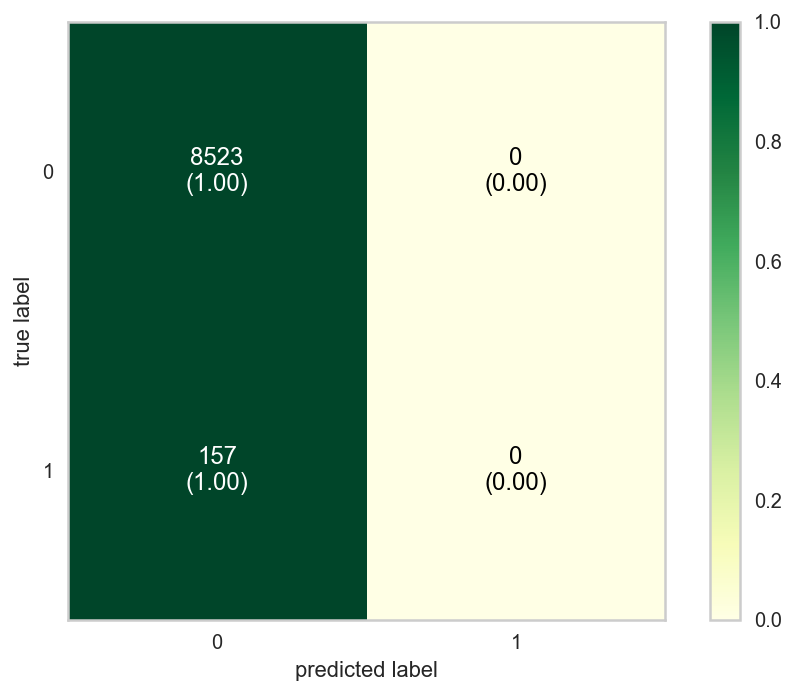

In [62]:
print ('\n*Classification Report:\n', classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True, cmap = 'YlGn')
plt.show()

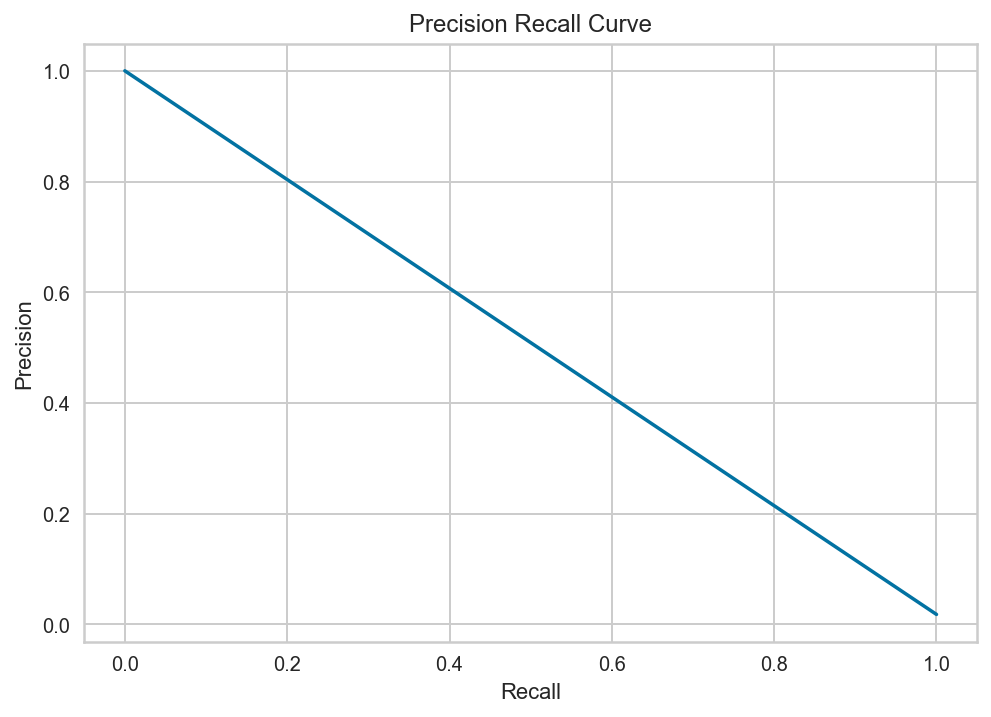

In [63]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision)
plt.title ('Precision Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [64]:
matthews_corrcoef(y_test, y_pred)

C:\Users\syami\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


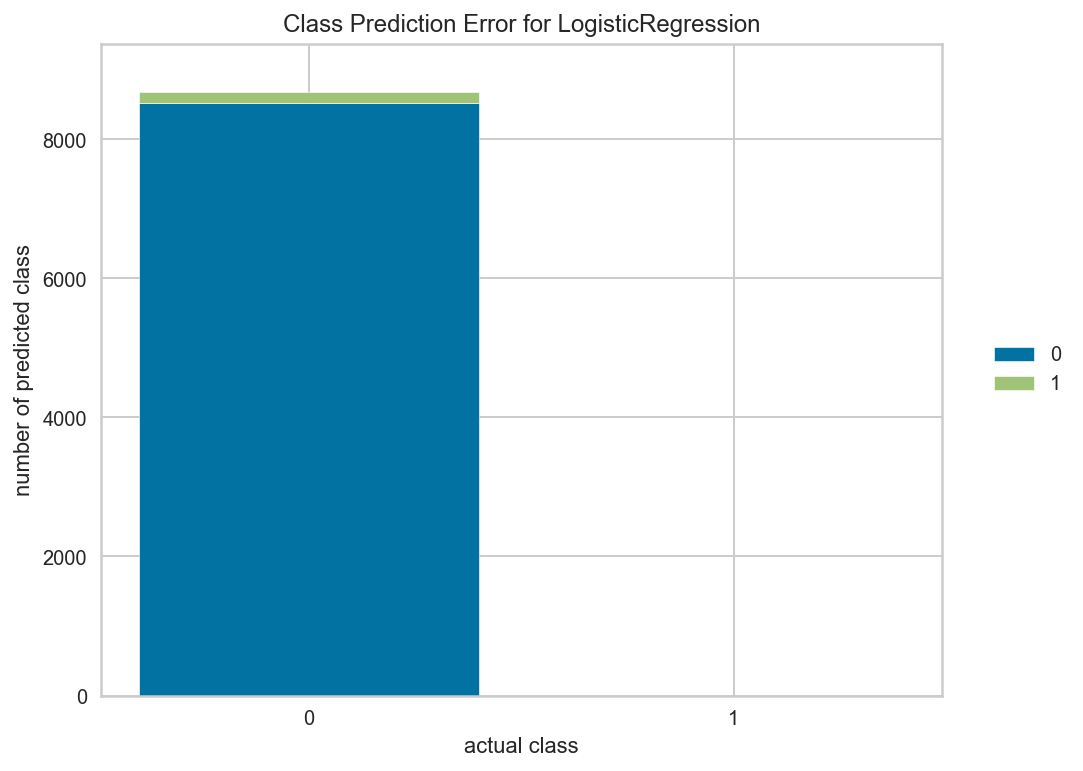

In [65]:
from yellowbrick.classifier import ClassPredictionError

# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(
    LogisticRegression(solver='lbfgs', max_iter = 1000, verbose = 3), classes=['0', '1']
)
# Fit the training data to the visualizer
visualizer.fit(x_train, y_train)

# Evaluate the model on the test data
visualizer.score(x_test, y_test)

# Draw visualization
g = visualizer.poof()

#### <font color = blue>Modeling and finetuning the parameters<font>

#### <font color = blue>XGBoost<font>

In [66]:
from xgboost import XGBClassifier
weights = (y == 0).sum() / (1.0 * (y == 1)).sum()
model = XGBClassifier(scale_pos_weight = weights, learning_rate =0.1, n_estimators=1000,
    max_depth=5, min_child_weight=1, gamma=0,subsample=0.8,colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4,seed=27 )


model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.8, gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=1, nthread=4,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=54.427841634738186, seed=27,
              silent=True, subsample=0.8)

In [67]:
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]


*Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      8523
         1.0       0.09      0.13      0.11       157

    accuracy                           0.96      8680
   macro avg       0.54      0.56      0.55      8680
weighted avg       0.97      0.96      0.96      8680



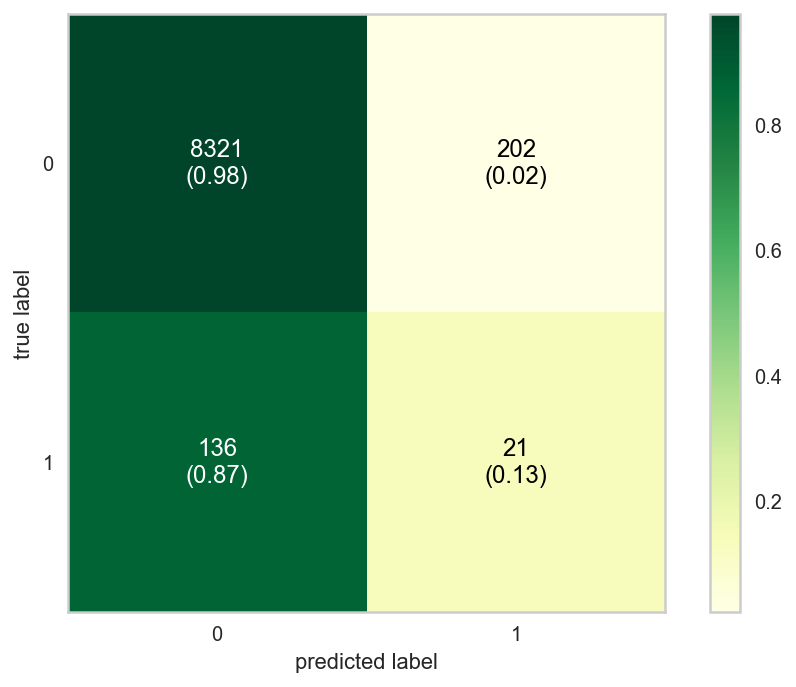

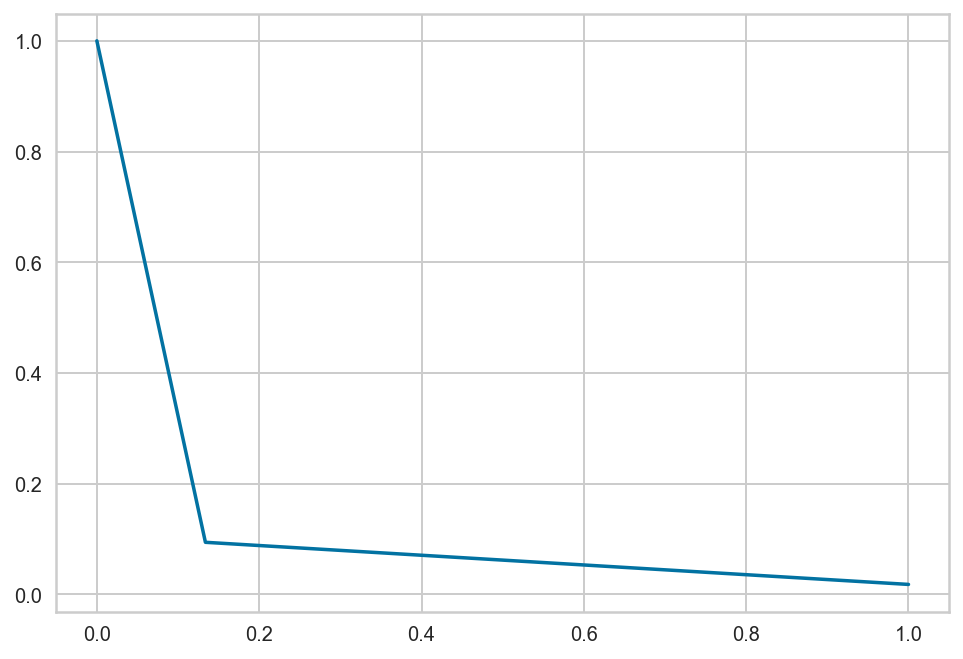

In [68]:
print ('\n*Classification Report:\n', classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True, cmap = 'YlGn')
plt.show()

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision)
plt.show()

C:\Users\syami\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


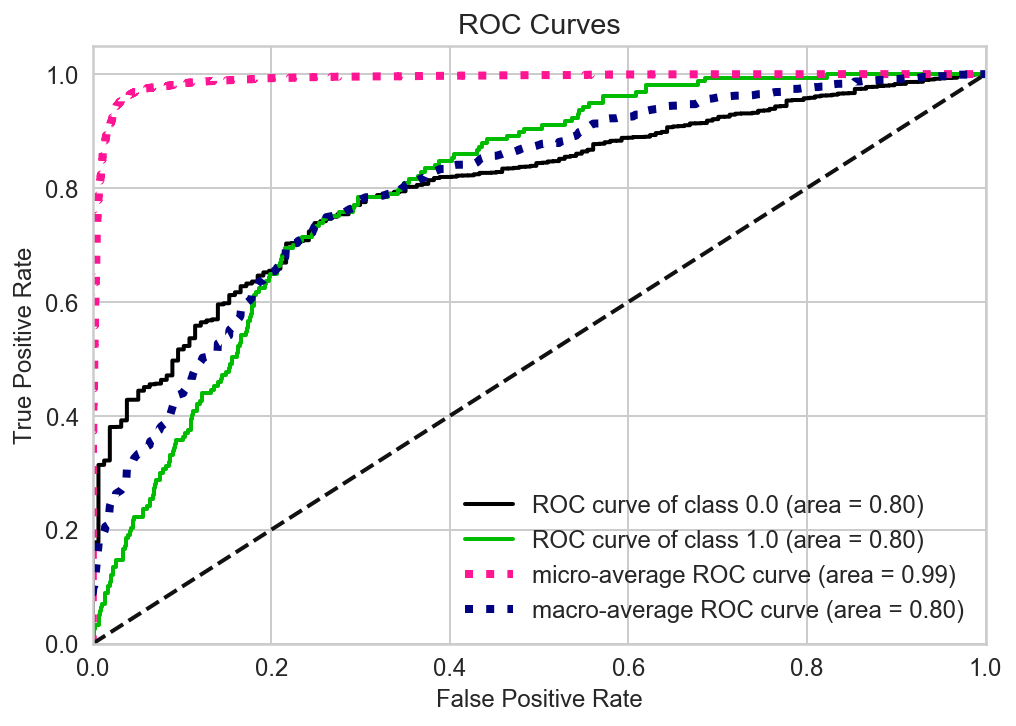

In [69]:
y_pred_proba = model.predict_proba(x_test)
skplt.metrics.plot_roc_curve(y_test, y_pred_proba)
plt.show()

In [70]:
matthews_corrcoef(y_test, y_pred)

0.09270532282938988

Text(0,0.5,'Features')

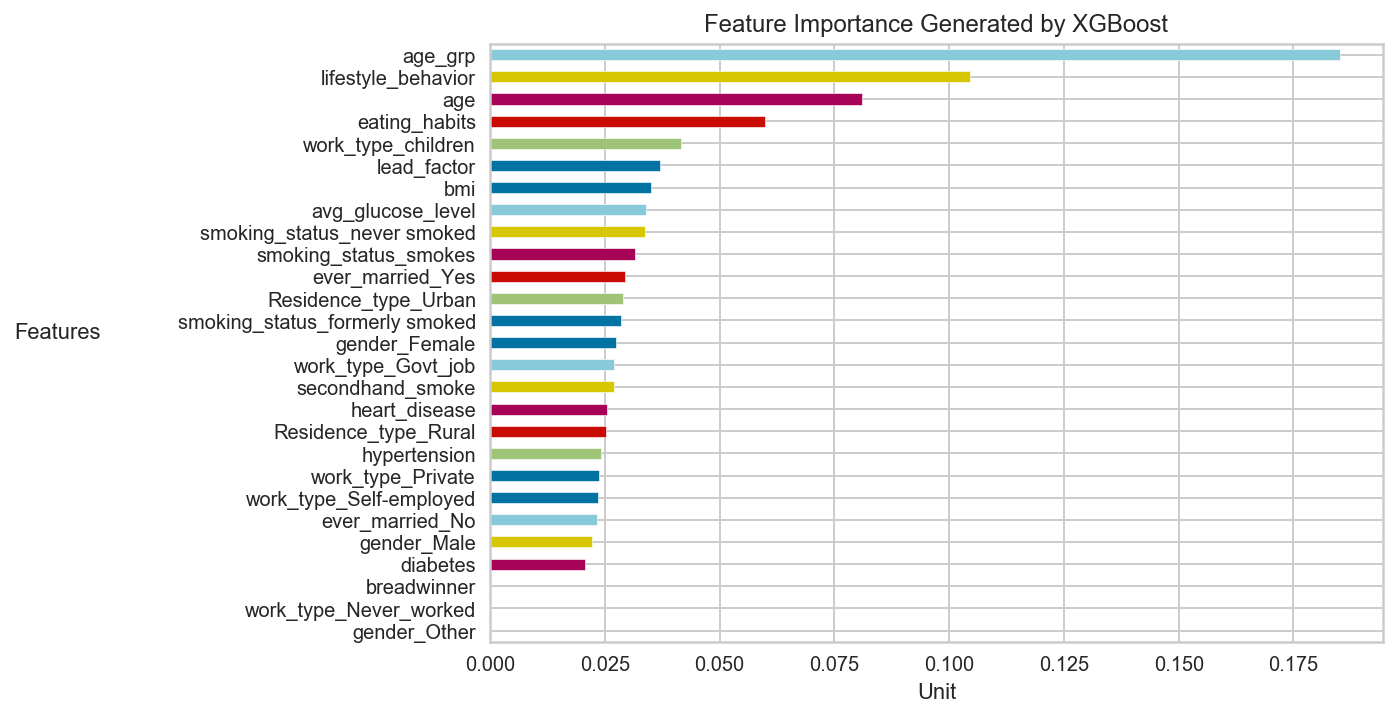

In [78]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh')
plt.title('Feature Importance Generated by XGBoost')
plt.xlabel ('Unit')
plt.ylabel('Features',rotation = 360, labelpad = 60)

Age_grp, Lifestyle behavior, age, eating habits, lead factor, bmi, avg glucose level, smoking status smokes and never smoked, secondhand smoke

In [54]:
# Specificity = tn/(tn+fp)
# print("Specificity {:0.2f}".format(Specificity))

# Sensitivity = tp/(tp+fn)
# print("Specificity {:0.2f}".format(Sensitivity))

In [79]:
from xgboost import XGBClassifier
weights = (y == 0).sum() / (1.0 * (y == 1)).sum()
model = XGBClassifier(scale_pos_weight = weights, learning_rate =0.1, n_estimators=1000, max_delta_step=0.5,
    max_depth=5, min_child_weight=1, gamma=0,subsample=0.8,colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4,seed=27 )
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.8, gamma=0, learning_rate=0.1,
              max_delta_step=0.5, max_depth=5, min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=1, nthread=4,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=54.427841634738186, seed=27,
              silent=True, subsample=0.8)


*Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.95      0.97      8523
         1.0       0.09      0.30      0.14       157

    accuracy                           0.94      8680
   macro avg       0.54      0.62      0.55      8680
weighted avg       0.97      0.94      0.95      8680



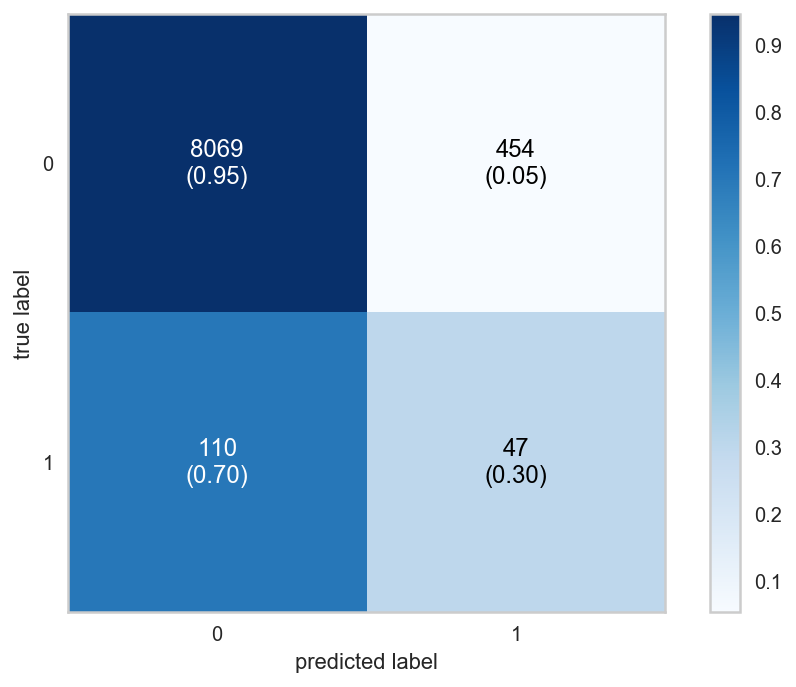

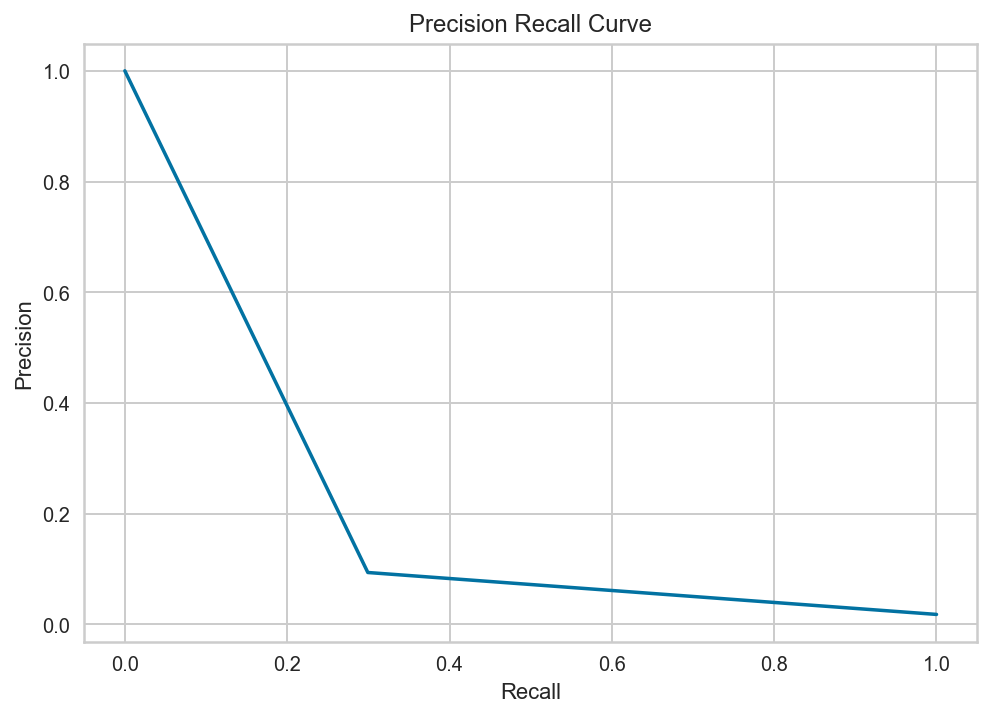

In [80]:
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]

print ('\n*Classification Report:\n', classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True, cmap = plt.cm.Blues)
plt.show()

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision)
plt.title ('Precision Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

C:\Users\syami\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


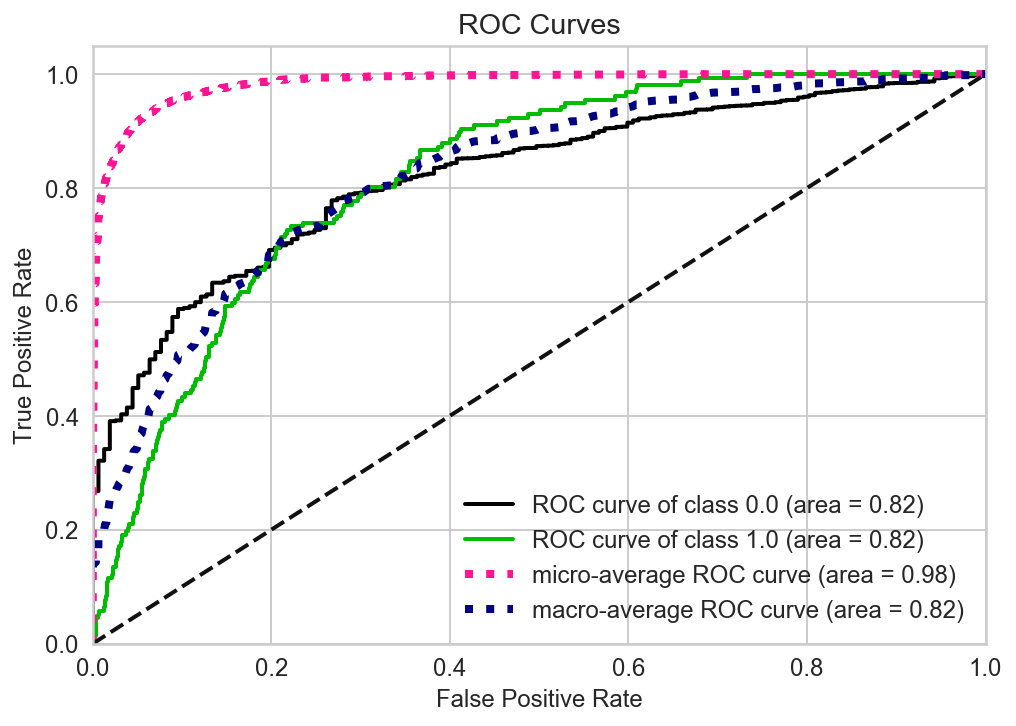

In [96]:
y_pred_proba = model.predict_proba(x_test)
skplt.metrics.plot_roc_curve(y_test, y_pred_proba)
plt.show()

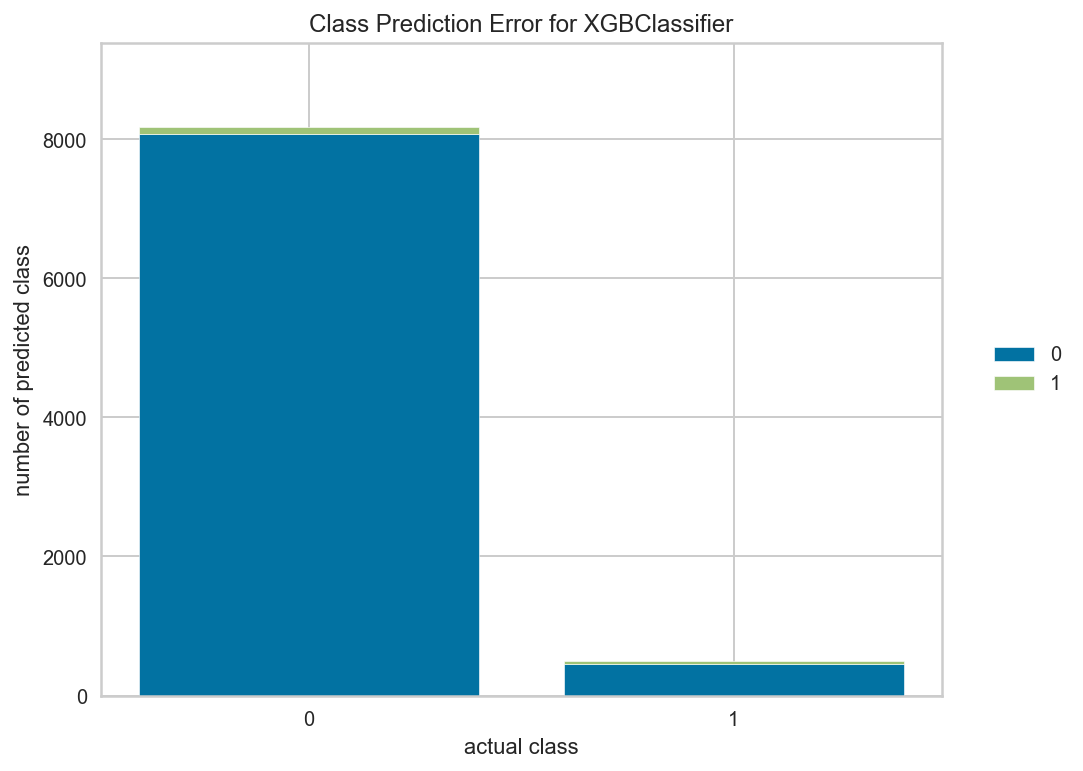

In [81]:
visualizer = ClassPredictionError(
    XGBClassifier(scale_pos_weight = weights, learning_rate =0.1, n_estimators=1000, max_delta_step=0.5,
    max_depth=5, min_child_weight=1, gamma=0,subsample=0.8,colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4,seed=27 ), classes=['0', '1']
)
# Fit the training data to the visualizer
visualizer.fit(x_train, y_train)

# Evaluate the model on the test data
visualizer.score(x_test, y_test)

# Draw visualization
g = visualizer.poof()

In [82]:
matthews_corrcoef(y_test, y_pred)

0.1406308655538113

In [36]:
X = training_sc[['age_grp', 'lifestyle_behavior', 'age', 'eating_habits',
                 'lead_factor','bmi', 'avg_glucose_level', 'smoking_status_smokes', 
                'smoking_status_never smoked', 'secondhand_smoke']]
y = training_sc['stroke']

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.20, random_state = 20, stratify = y)

from xgboost import XGBClassifier
weights = (y == 0).sum() / (1.0 * (y == 1)).sum()
model = XGBClassifier(scale_pos_weight = weights, learning_rate =0.1, n_estimators=1000, max_delta_step=0.5,
    max_depth=5, min_child_weight=1, gamma=0,subsample=0.8,colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4,seed=27 )
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.8, gamma=0, learning_rate=0.1,
              max_delta_step=0.5, max_depth=5, min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=1, nthread=4,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=54.427841634738186, seed=27,
              silent=True, subsample=0.8)


*Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.93      0.96      8523
         1.0       0.08      0.31      0.12       157

    accuracy                           0.92      8680
   macro avg       0.53      0.62      0.54      8680
weighted avg       0.97      0.92      0.94      8680



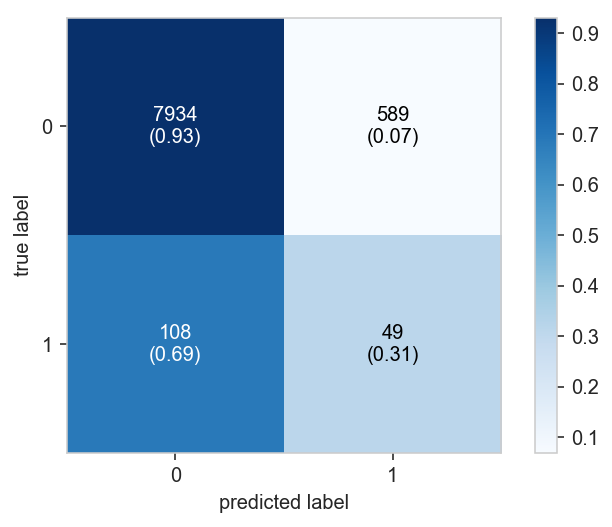

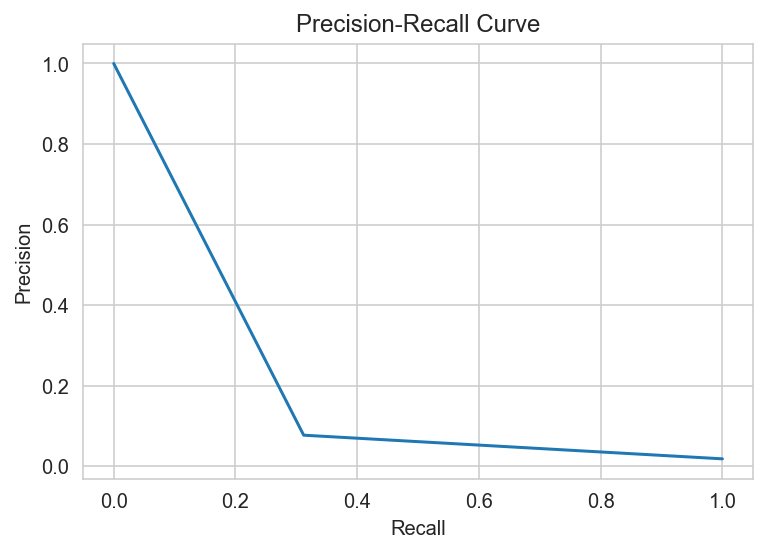

In [37]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

print ('\n*Classification Report:\n', classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True, cmap = plt.cm.Blues)
plt.show()

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision)
plt.title ('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

C:\Users\syami\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


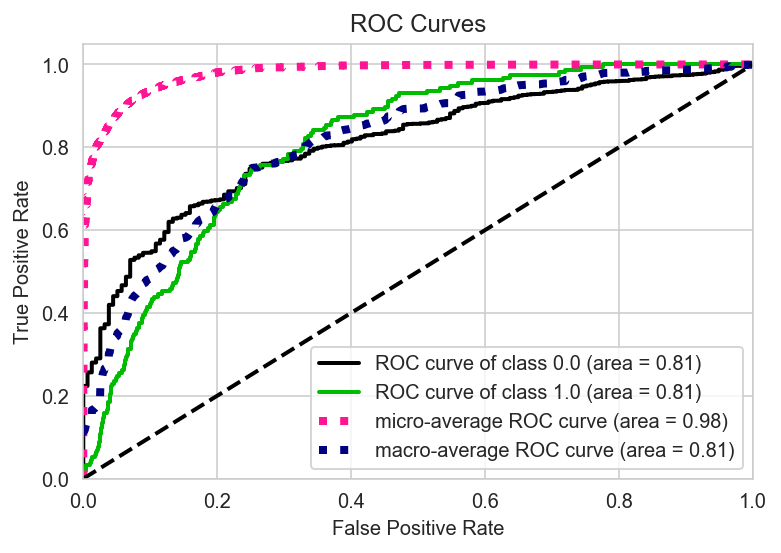

In [38]:
y_pred_proba = model.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_pred_proba)
plt.show()

In [39]:
from xgboost import XGBClassifier
weights = (y == 0).sum() / (1.0 * (y == 1)).sum()
model = XGBClassifier(scale_pos_weight = weights, learning_rate =0.1, n_estimators=1000, max_delta_step=10,
    max_depth=5, min_child_weight=1, gamma=0,subsample=0.8,colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4,seed=27 )
model.fit(x_train, y_train)

NameError: name 'x_train' is not defined


*Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      8523
         1.0       0.09      0.13      0.11       157

    accuracy                           0.96      8680
   macro avg       0.54      0.55      0.54      8680
weighted avg       0.97      0.96      0.96      8680



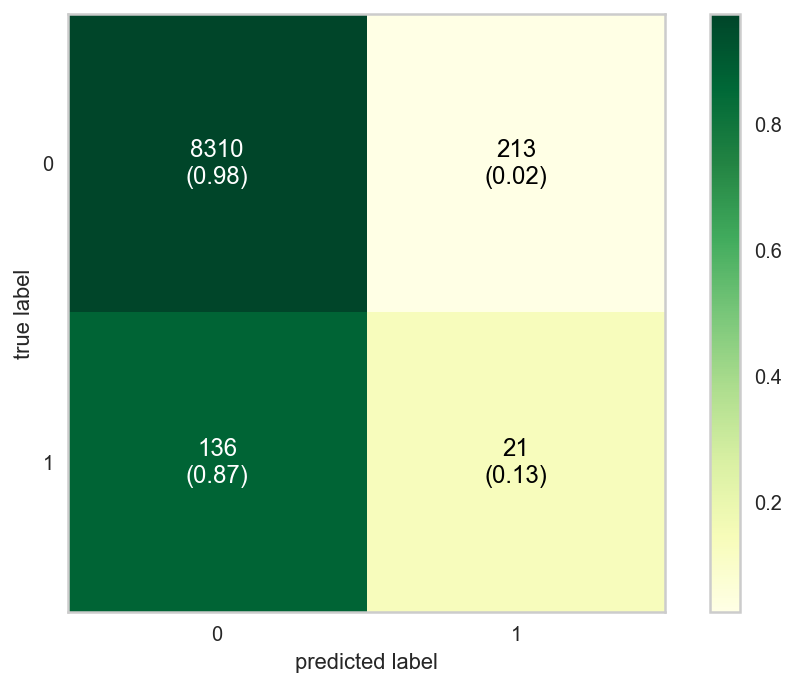

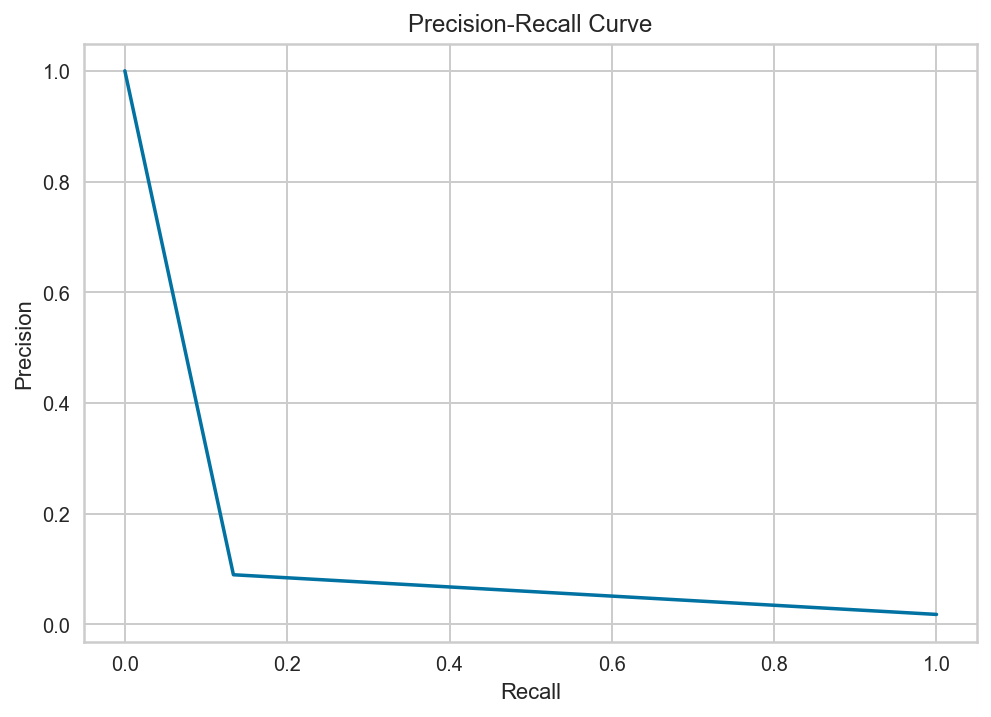

In [58]:
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]

print ('\n*Classification Report:\n', classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True, cmap = plt.cm.Blues)
plt.show()

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision)
plt.title ('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

#### <font color = blue>Using RFclassifier VS bagging classifier<font>

In [59]:
def fit_model(x_train,x_test,y_train,y_test):
    classifiers={"Random Forest":RandomForestClassifier(),
                 "Bagging-Decision Tree":BaggingClassifier(),}
    fig, ax = plt.subplots(1,2,figsize=(12,6))
    i=0

    for key, classifier in classifiers.items():
        classifier.fit(x_train, y_train)
        y_pred=classifier.predict(x_test)
        cm=confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, ax=ax[i], annot=True,
                    cmap=plt.cm.Blues,
                   xticklabels=['No Stroke', 'Stroke'],
                   yticklabels=['No Stroke', 'Stroke']).set_title(key)

        i+=1
        print ('\n*Classification Report:\n', classifier, '\n', classification_report(y_test, y_pred))
    plt.show()

In [60]:
print ('y_train shape: ', y_train.shape)
print ('y_test shape: ', y_test.shape)

y_train shape:  (34720,)
y_test shape:  (8680,)


C:\Users\syami\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



*Classification Report:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      8523
         1.0       0.00      0.00      0.00       157

    accuracy                           0.98      8680
   macro avg       0.49      0.50      0.50      8680
weighted avg       0.96      0.98      0.97      8680


*Classification Report:
 BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=

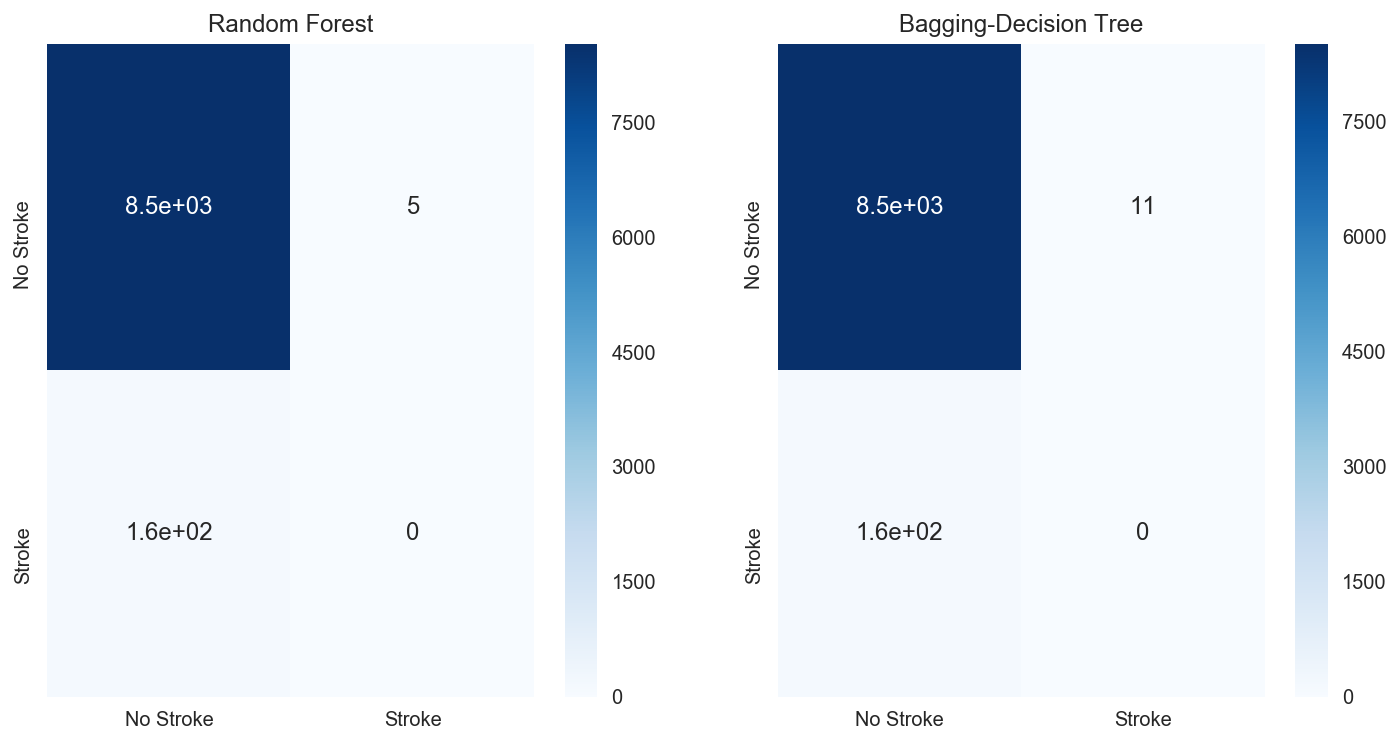

In [61]:
fit_model(x_train,x_test,y_train,y_test)

In [62]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time
import matplotlib.patches as mpatches


def plot_dim(x,y):
    # T-SNE Implementation
    t0 = time.time()
    X_reduced_tsne = TSNE(n_components=2, random_state=10).fit_transform(x)
    t1 = time.time()
    print("T-SNE took {:.2} s".format(t1 - t0))    

    # PCA Implementation
    t0 = time.time()
    X_reduced_pca = PCA(n_components=2, random_state=10).fit_transform(x)
    t1 = time.time()
    print("PCA took {:.2} s".format(t1 - t0))

    # TruncatedSVD
    t0 = time.time()
    X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=10).fit_transform(x)
    t1 = time.time()
    print("Truncated SVD took {:.2} s".format(t1 - t0))

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
    # labels = ['No Fraud', 'Fraud']
    f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


    blue_patch = mpatches.Patch(color='#0A0AFF', label='No Stroke')
    red_patch = mpatches.Patch(color='#AF0000', label='Stroke')


    # t-SNE scatter plot
    ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], s=4, c=(y == 0),
                cmap='coolwarm', label='No Stroke', linewidths=2)
    ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], s=4, c=(y == 1),
                cmap='coolwarm', label='Stroke', linewidths=2)
    ax1.set_title('t-SNE', fontsize=14)

    ax1.grid(True)

    ax1.legend(handles=[blue_patch, red_patch])


    # PCA scatter plot
    ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], s=4, c=(y == 0),
                cmap='coolwarm', label='No Stroke', linewidths=2)
    ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], s=4, c=(y == 1),
                cmap='coolwarm', label='Stroke', linewidths=2)
    ax2.set_title('PCA', fontsize=14)

    ax2.grid(True)

    ax2.legend(handles=[blue_patch, red_patch])

    # TruncatedSVD scatter plot
    ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], s=4, c=(y == 0),
                cmap='coolwarm', label='No Stroke', linewidths=2)
    ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], s=4, c=(y == 1),
                cmap='coolwarm', label='Stroke', linewidths=2)
    ax3.set_title('Truncated SVD', fontsize=14)

    ax3.grid(True)

    ax3.legend(handles=[blue_patch, red_patch])

    plt.show()

#### <font color = blue>Baseline of x_test vs y_test without any resampling techniques done<font>

T-SNE took 1.7e+02 s
PCA took 0.072 s
Truncated SVD took 0.037 s


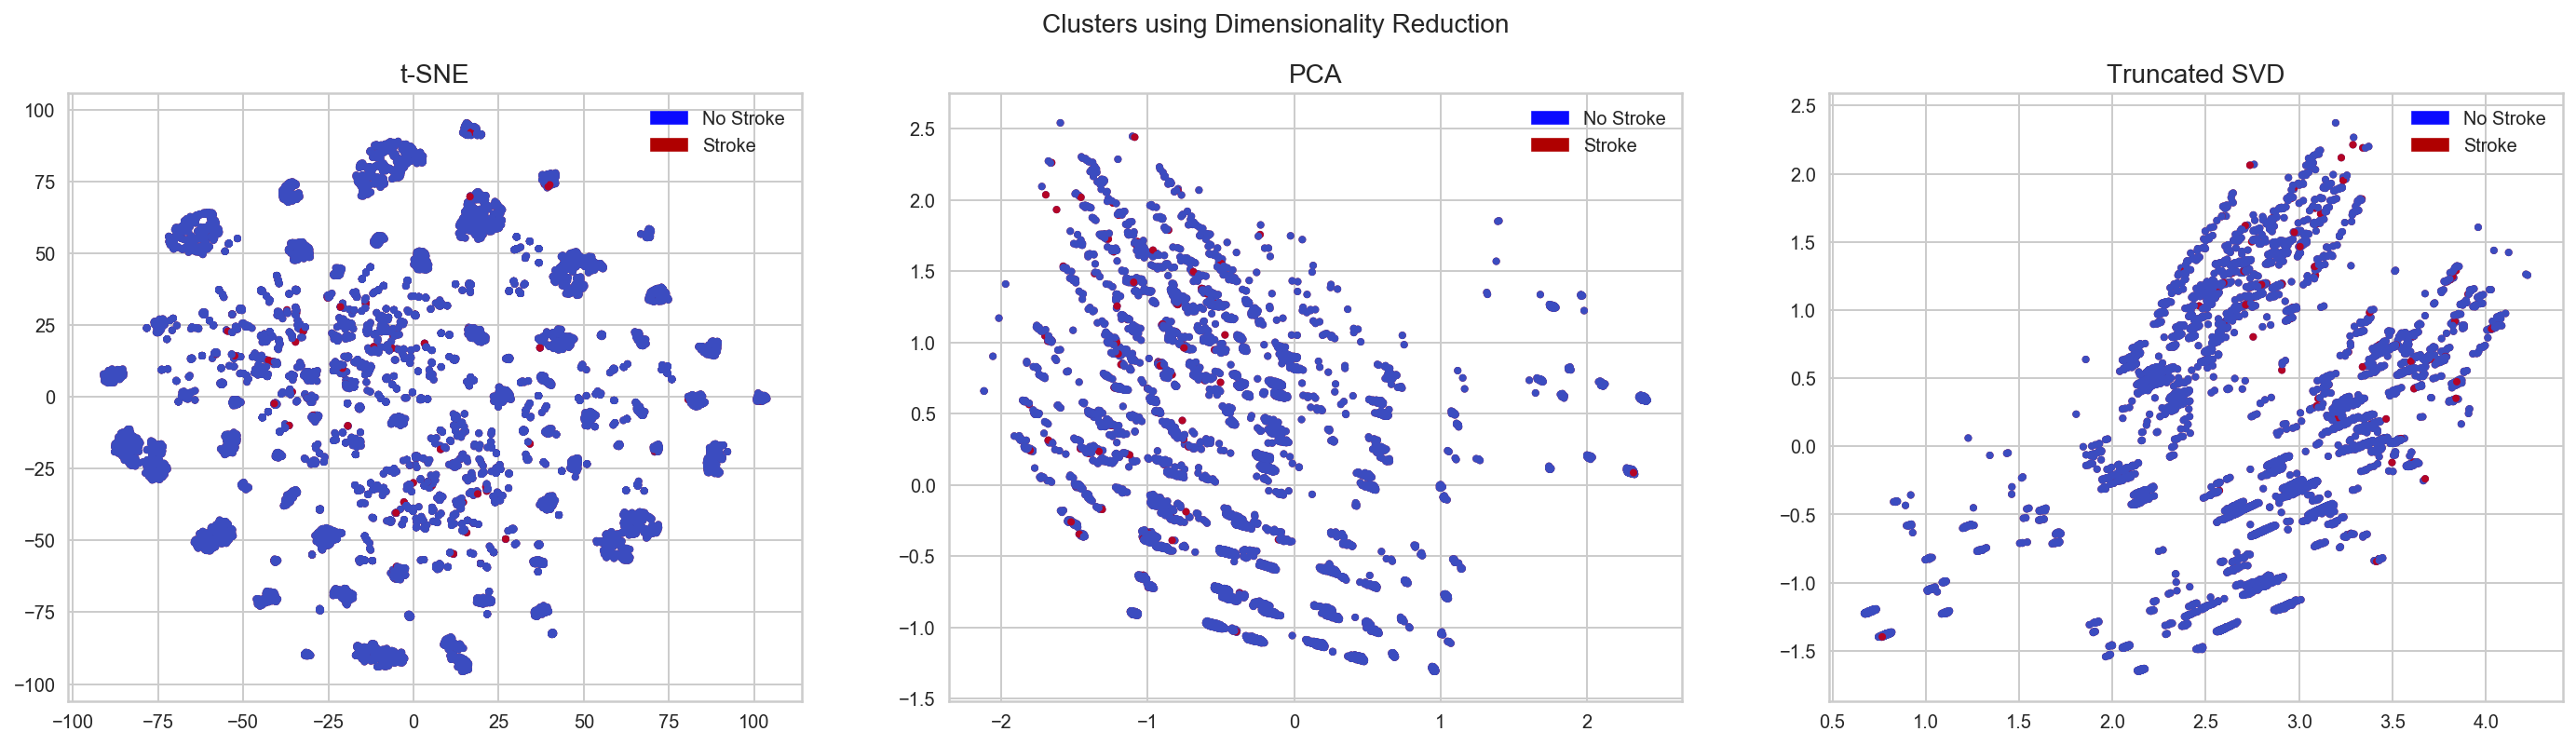

In [63]:
x_train_plot,x_plot,y_train_plot,y_plot=train_test_split(X,y,test_size=0.2, stratify=y, random_state=0)
plot_dim(x_plot,y_plot)

#### <font color = blue>Using Tomek-links (downsample) and resampling<font>

In [64]:
from imblearn.under_sampling import TomekLinks
tomekl = TomekLinks(random_state=0,n_jobs=3)
x_tomekl, y_tomekl = tomekl.fit_sample(x_train, y_train)

from sklearn.utils import resample
x_tomekl_plot,y_tomekl_plot=resample(x_tomekl,y_tomekl,n_samples=10000,random_state=0)

T-SNE took 2.2e+02 s
PCA took 0.053 s
Truncated SVD took 0.039 s


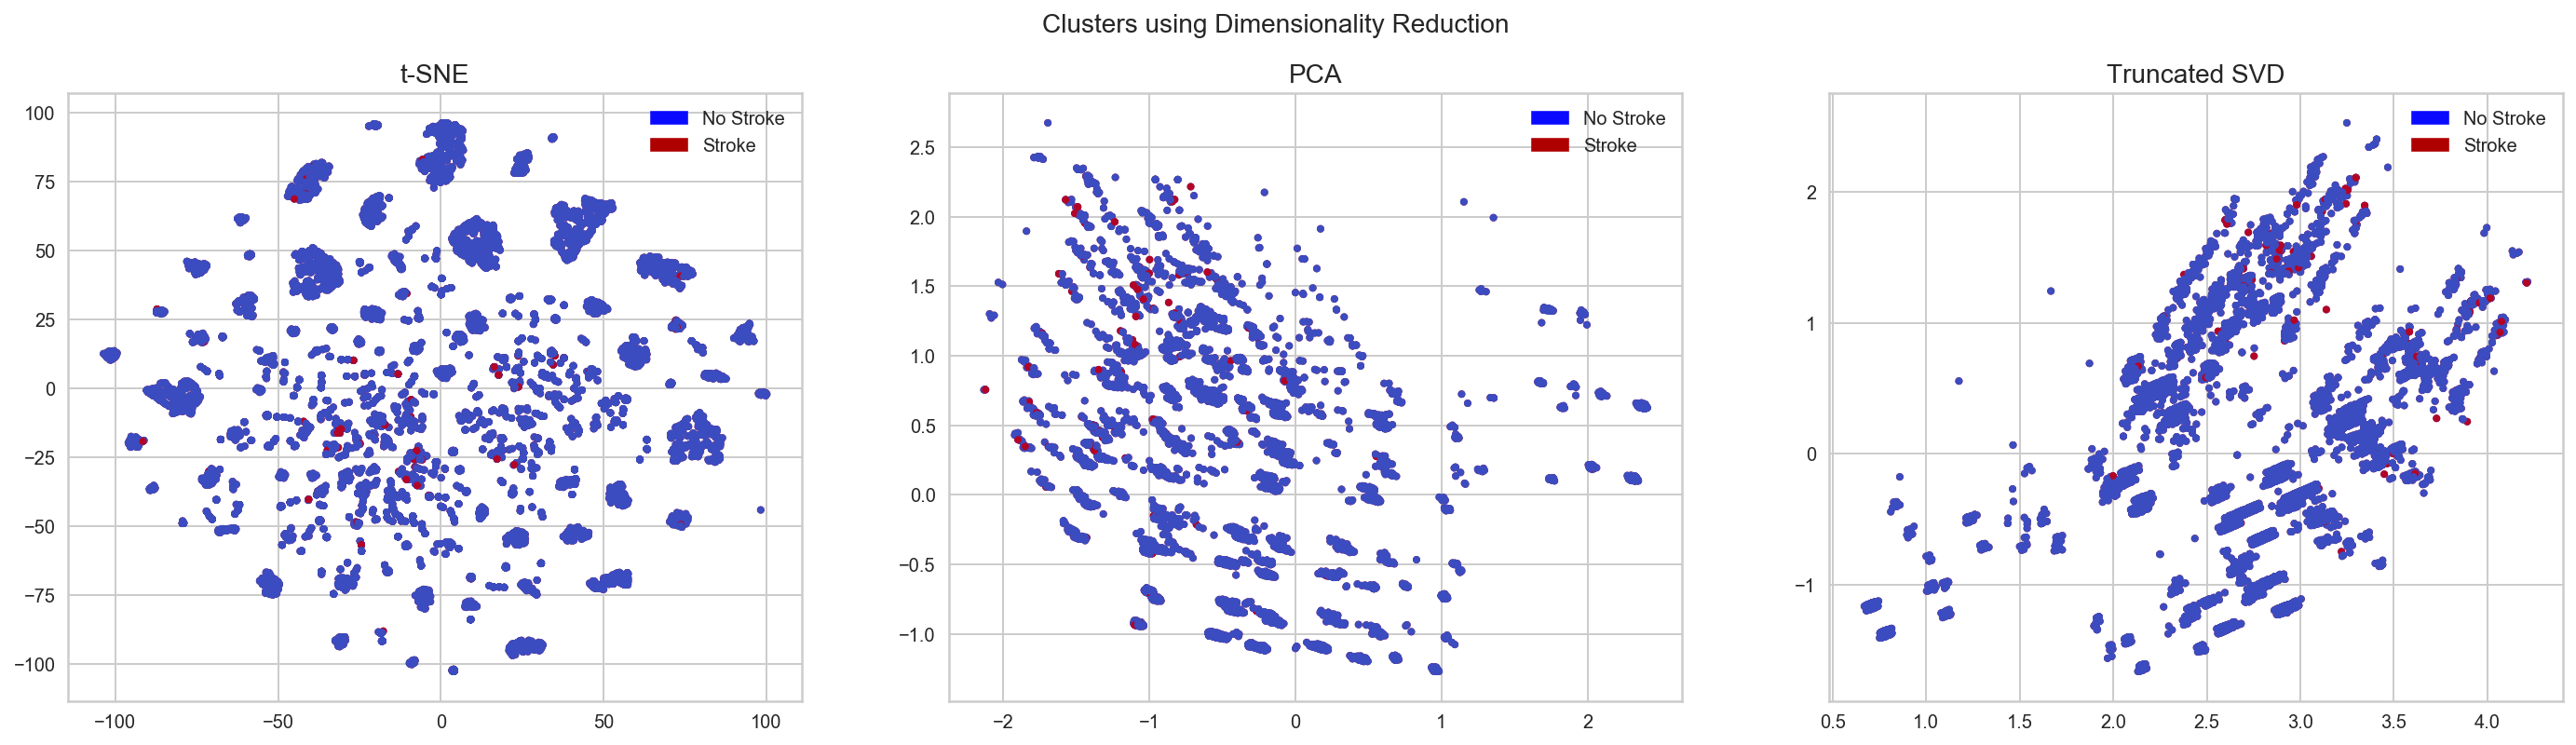

In [65]:
plot_dim(x_tomekl_plot,y_tomekl_plot)

C:\Users\syami\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



*Classification Report:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      8523
         1.0       0.09      0.01      0.01       157

    accuracy                           0.98      8680
   macro avg       0.54      0.50      0.50      8680
weighted avg       0.97      0.98      0.97      8680


*Classification Report:
 BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=

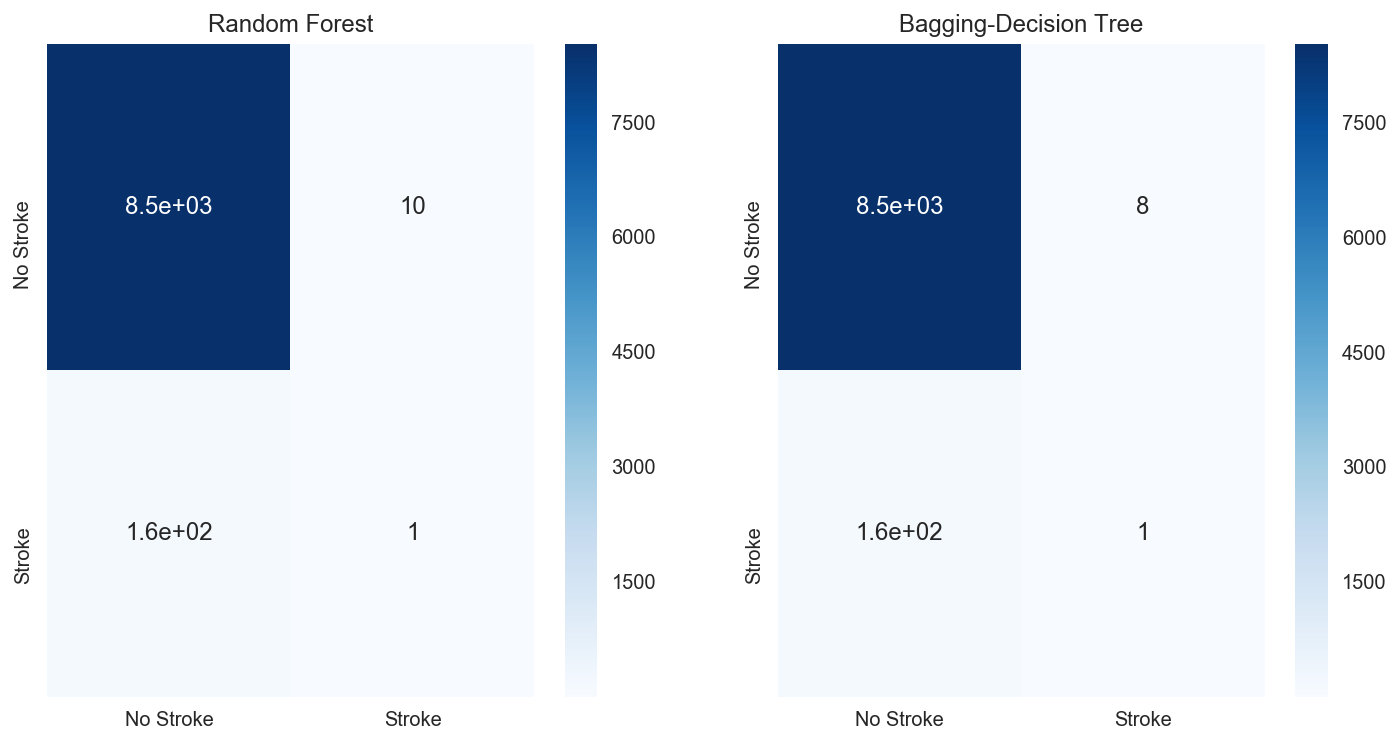

In [66]:
fit_model(x_tomekl,x_test,y_tomekl,y_test)

#### <font color = blue> Upsampling, using SMOTE vs ADASYN<font>

T-SNE took 2.1e+02 s
PCA took 0.051 s
Truncated SVD took 0.038 s


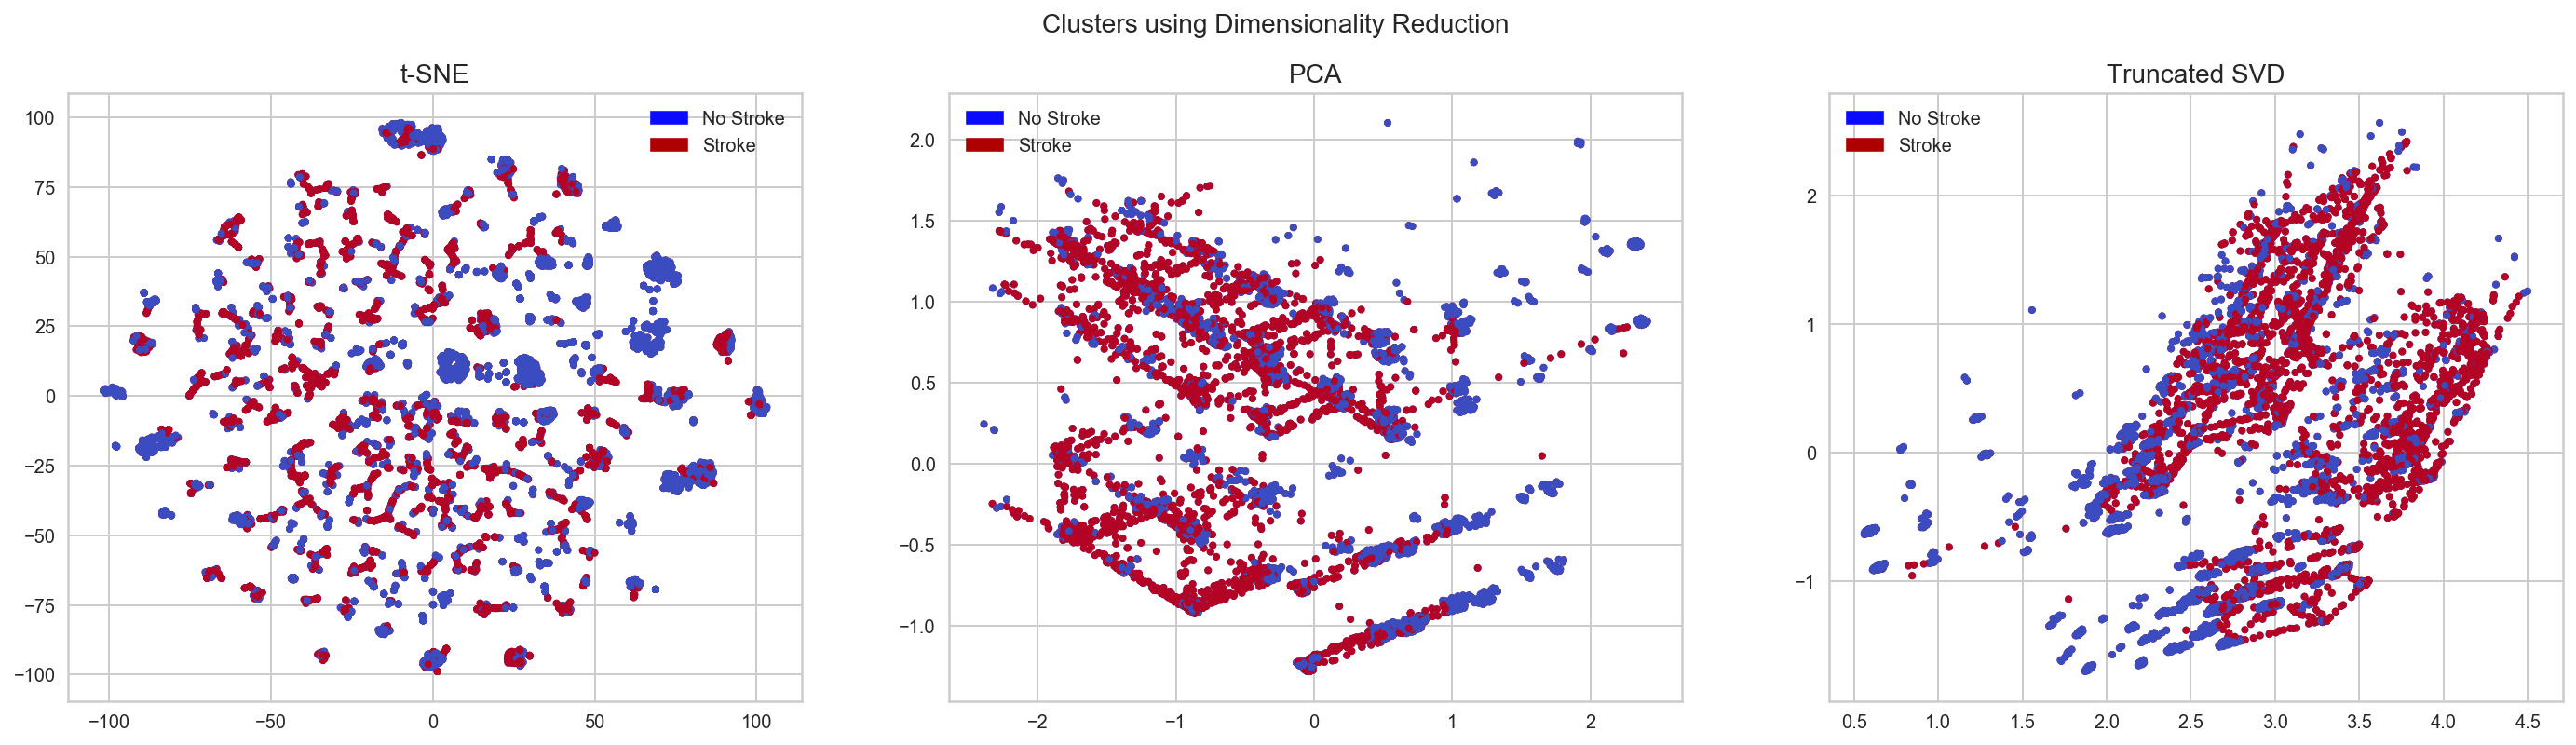

In [67]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)
x_smote, y_smote = sm.fit_sample(x_train, y_train)

x_smote_plot,y_smote_plot=resample(x_smote,y_smote,n_samples=10000,random_state=0)
plot_dim(x_smote_plot,y_smote_plot)

C:\Users\syami\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



*Classification Report:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      8523
         1.0       0.05      0.07      0.06       157

    accuracy                           0.96      8680
   macro avg       0.52      0.52      0.52      8680
weighted avg       0.97      0.96      0.96      8680


*Classification Report:
 BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=

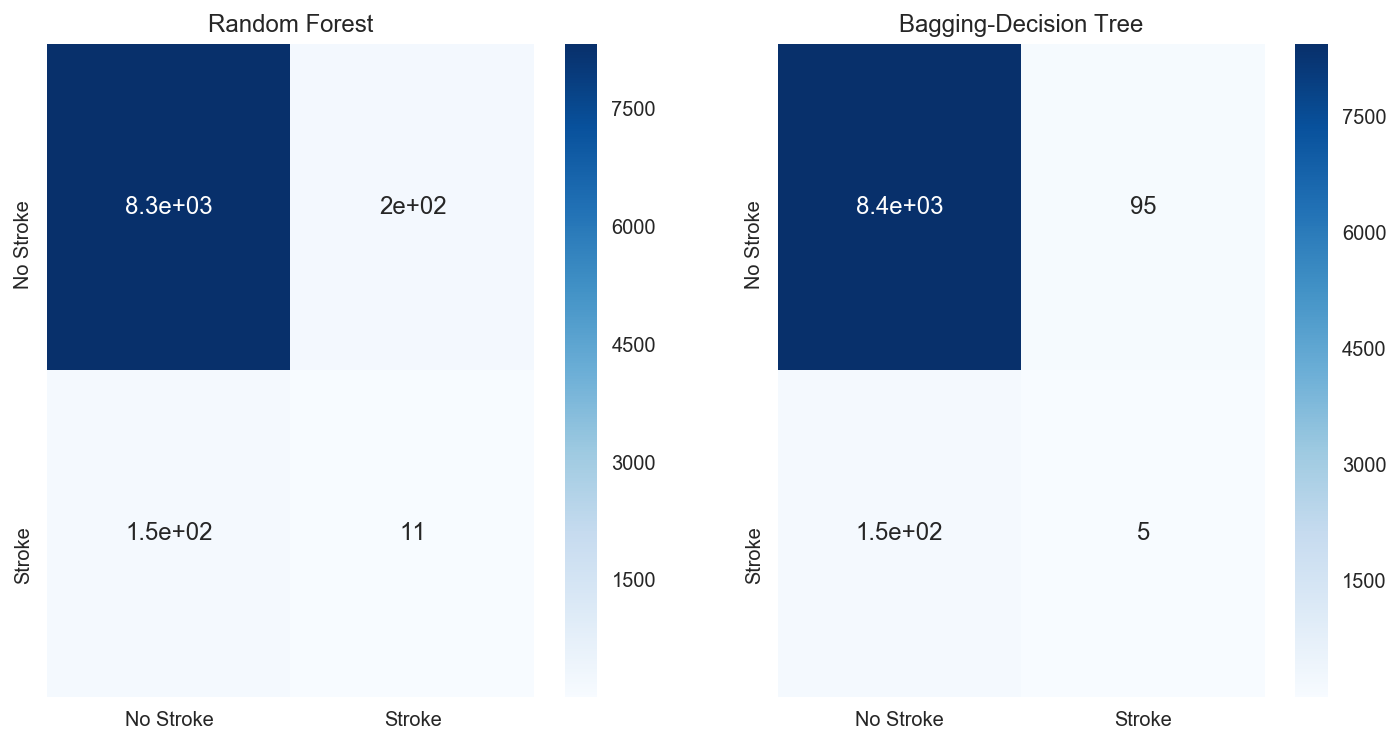

In [68]:
fit_model(x_smote,x_test,y_smote,y_test)

T-SNE took 2.1e+02 s
PCA took 0.052 s
Truncated SVD took 0.038 s


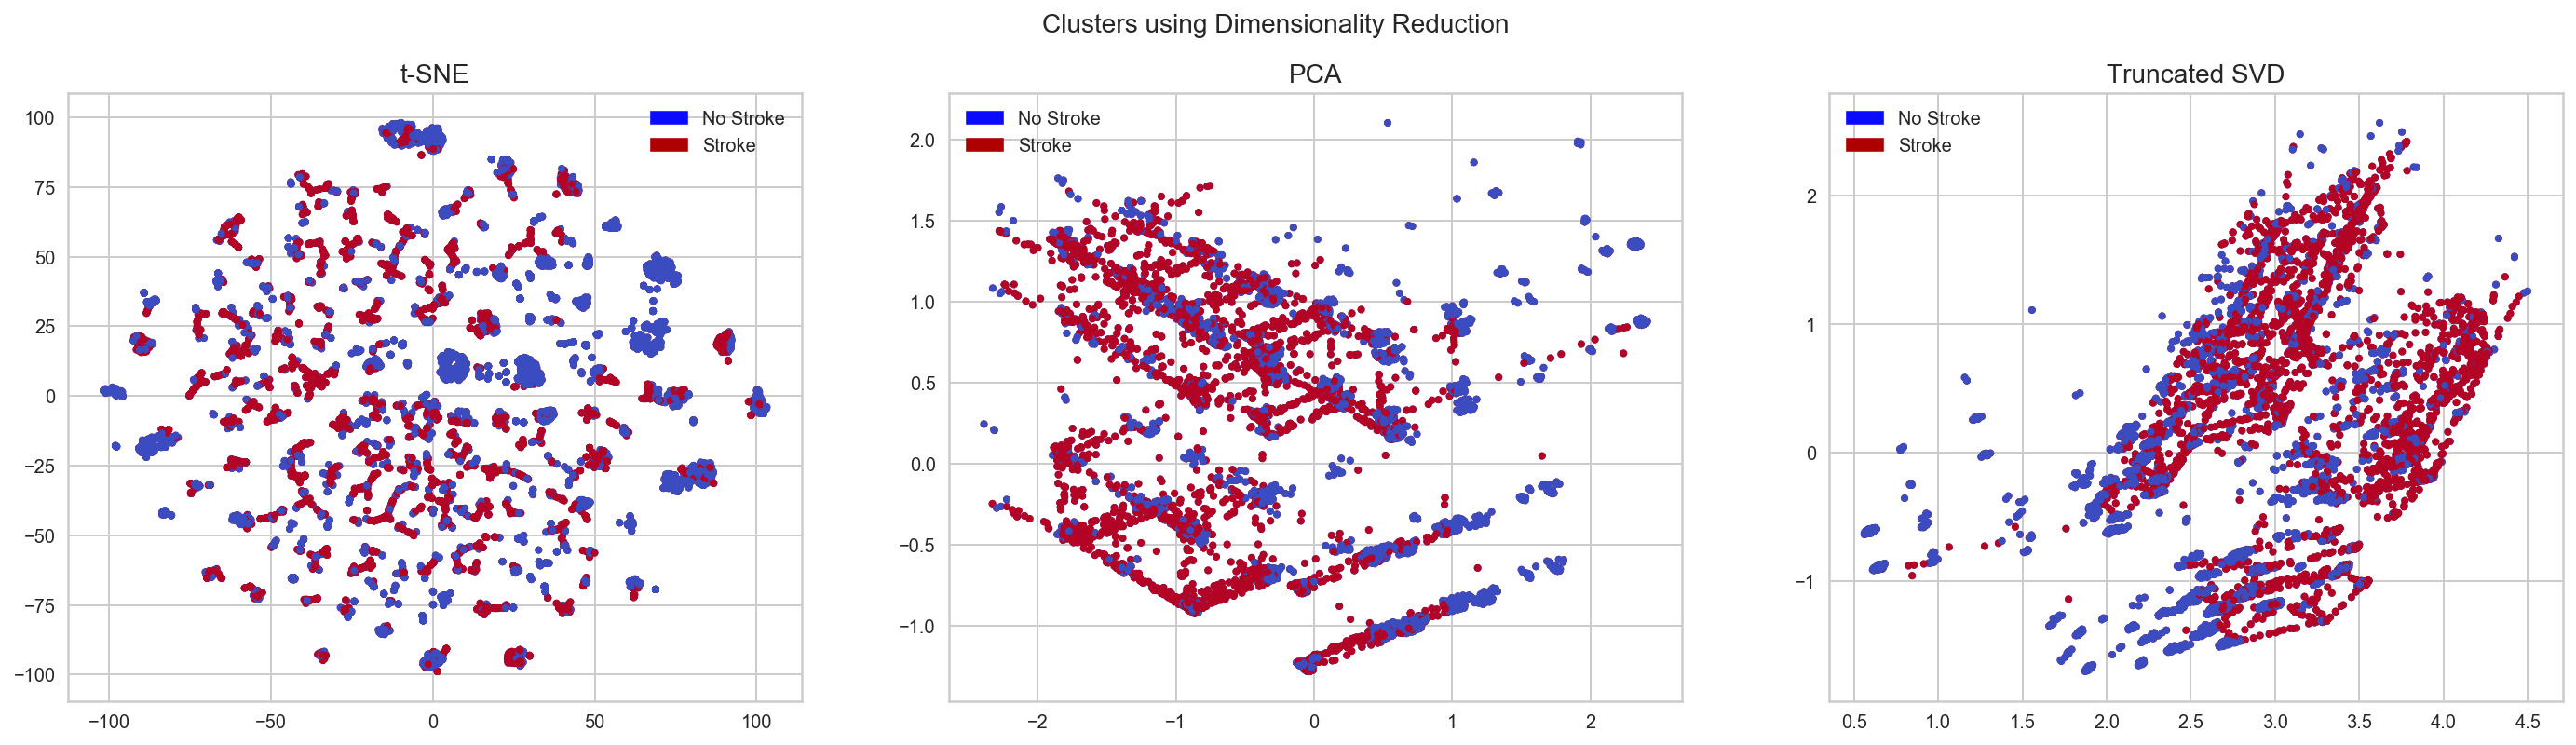

In [69]:
from imblearn.over_sampling import ADASYN
ada = ADASYN()
x_ada, y_ada = sm.fit_sample(x_train, y_train)

x_ada_plot,y_ada_plot=resample(x_ada,y_ada,n_samples=10000,random_state=0)
plot_dim(x_ada_plot,y_ada_plot)

C:\Users\syami\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



*Classification Report:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      8523
         1.0       0.05      0.06      0.05       157

    accuracy                           0.96      8680
   macro avg       0.52      0.52      0.52      8680
weighted avg       0.97      0.96      0.96      8680


*Classification Report:
 BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=

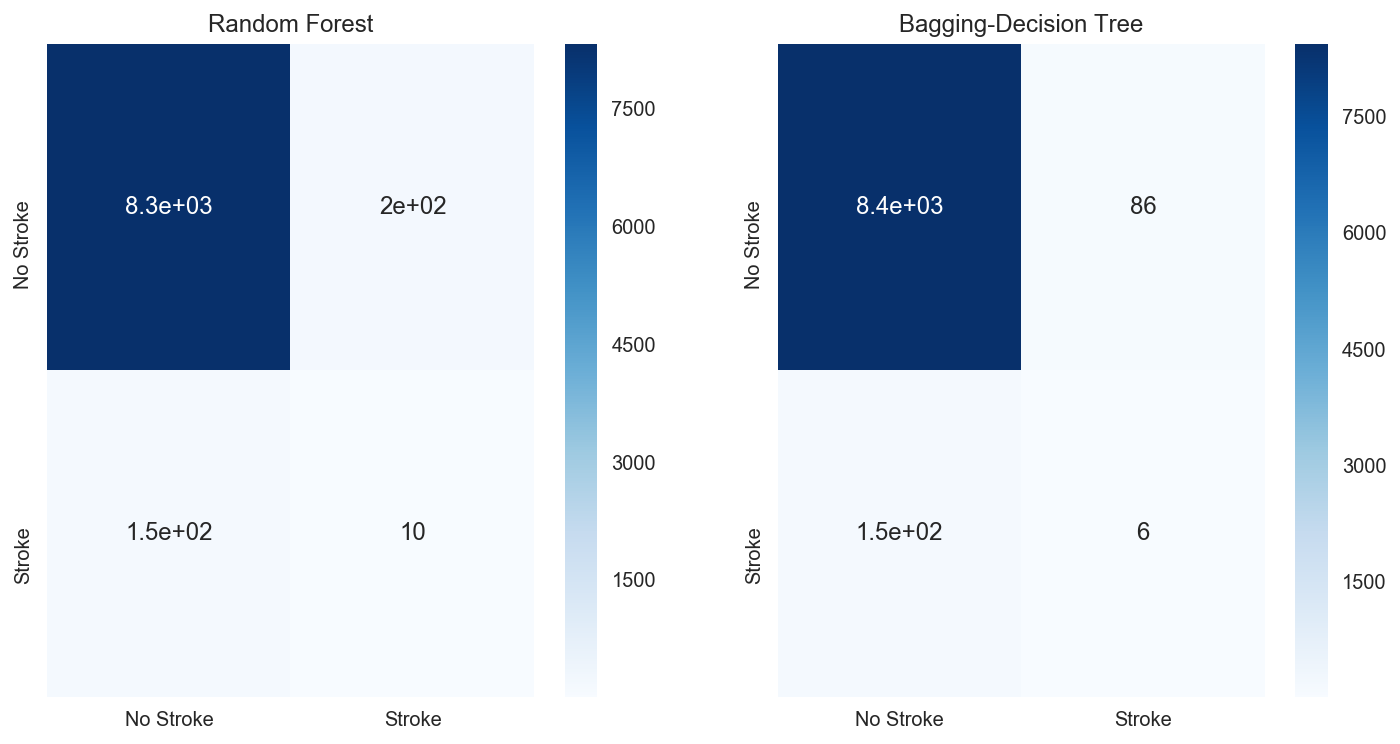

In [70]:
fit_model(x_ada,x_test,y_ada,y_test)

#### <font color = blue>Combine upsampling & downsampling, using SMOTEENN vs SMOTE TOMEK.<font>
SMOTEENN = SMOTE (oversampling) + ENN (undersampling) vs SMOTE (oversampling) + TOMEK (undersampling)<font>

T-SNE took 2.1e+02 s
PCA took 0.051 s
Truncated SVD took 0.039 s


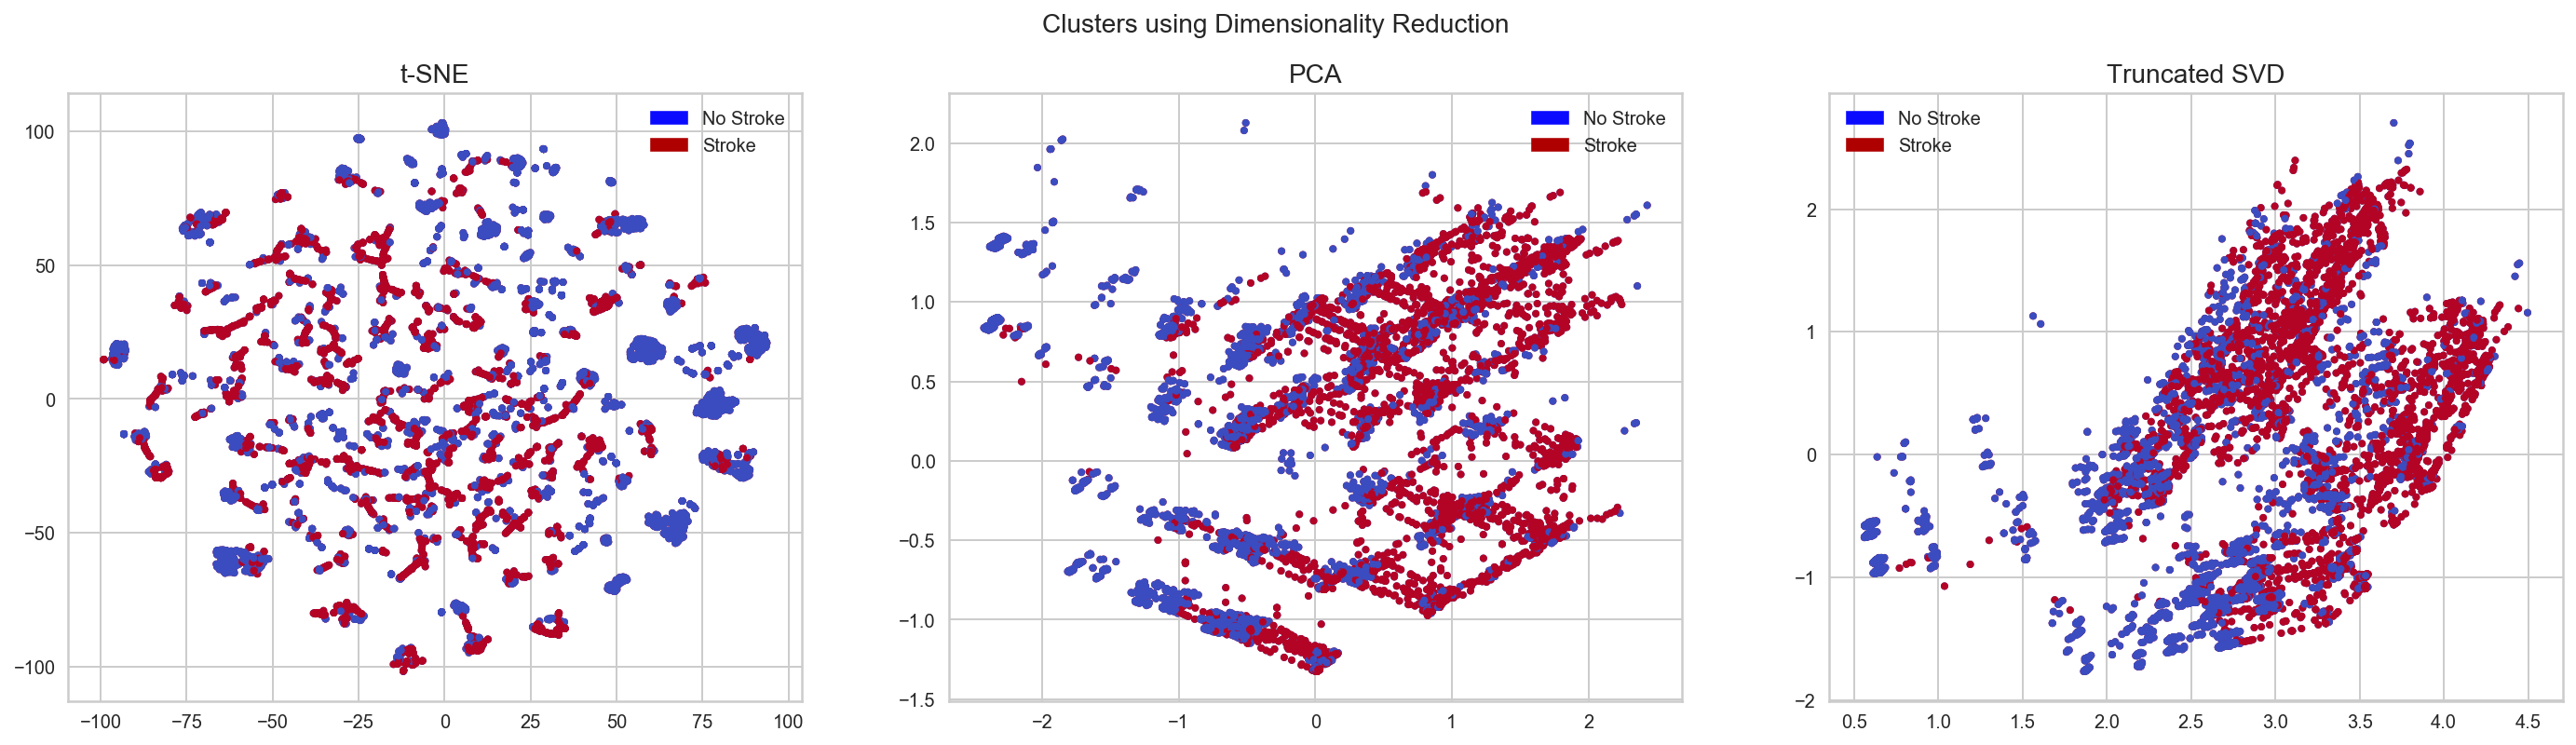

In [71]:
from imblearn.combine import SMOTEENN
enn = SMOTEENN(random_state=42)
x_enn, y_enn = enn.fit_resample(x_train, y_train)

x_enn_plot,y_enn_plot=resample(x_enn,y_enn,n_samples=10000,random_state=0)
plot_dim(x_enn_plot,y_enn_plot)

C:\Users\syami\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



*Classification Report:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 
               precision    recall  f1-score   support

         0.0       0.98      0.95      0.97      8523
         1.0       0.06      0.17      0.09       157

    accuracy                           0.94      8680
   macro avg       0.52      0.56      0.53      8680
weighted avg       0.97      0.94      0.95      8680


*Classification Report:
 BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=

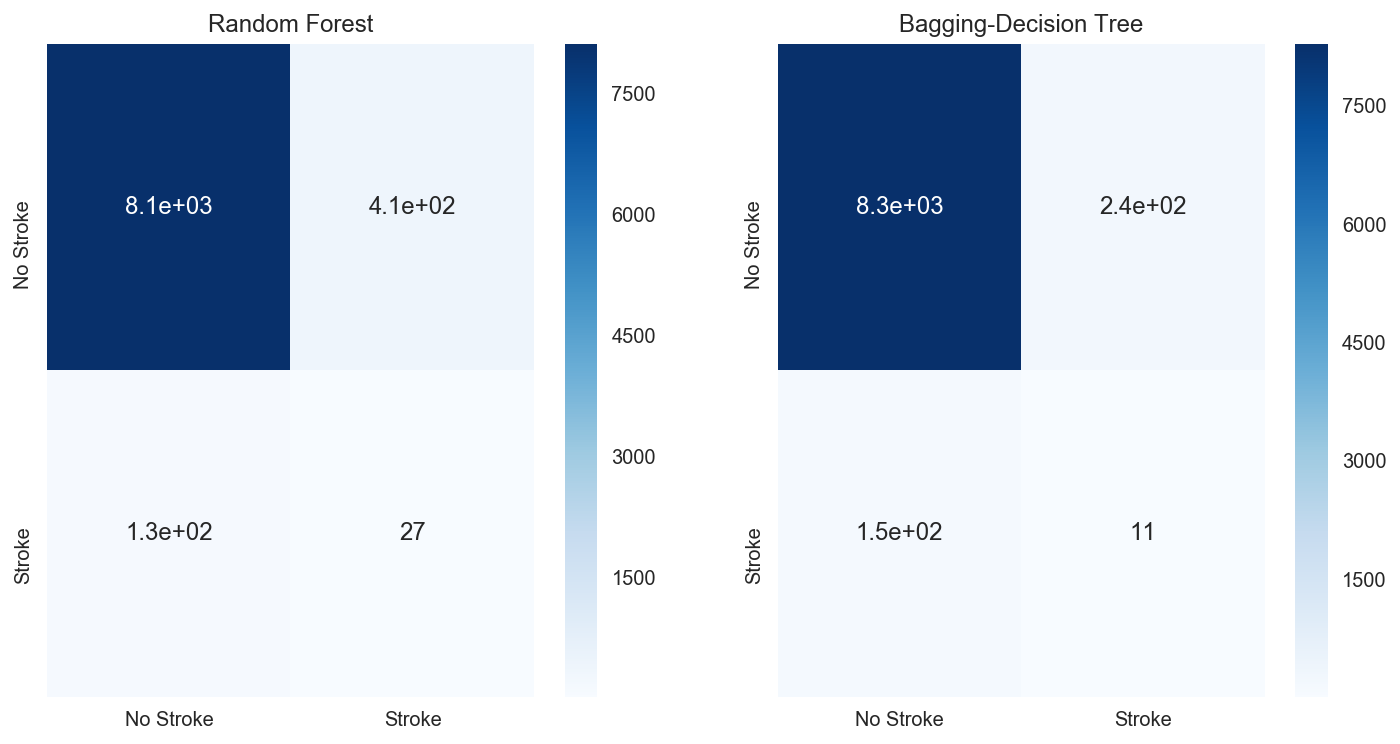

In [72]:
fit_model(x_enn,x_test,y_enn,y_test)

In [83]:
from imblearn.combine import SMOTEENN
enn = SMOTEENN(random_state=42)
x_enn, y_enn = enn.fit_resample(x_train, y_train)

In [84]:
rfc = RandomForestClassifier()
rfc.fit (x_enn, y_enn)
y_pred = rfc.predict(x_test)

from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, y_pred)

C:\Users\syami\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.09286752124285104

T-SNE took 2.3e+02 s
PCA took 0.052 s
Truncated SVD took 0.046 s


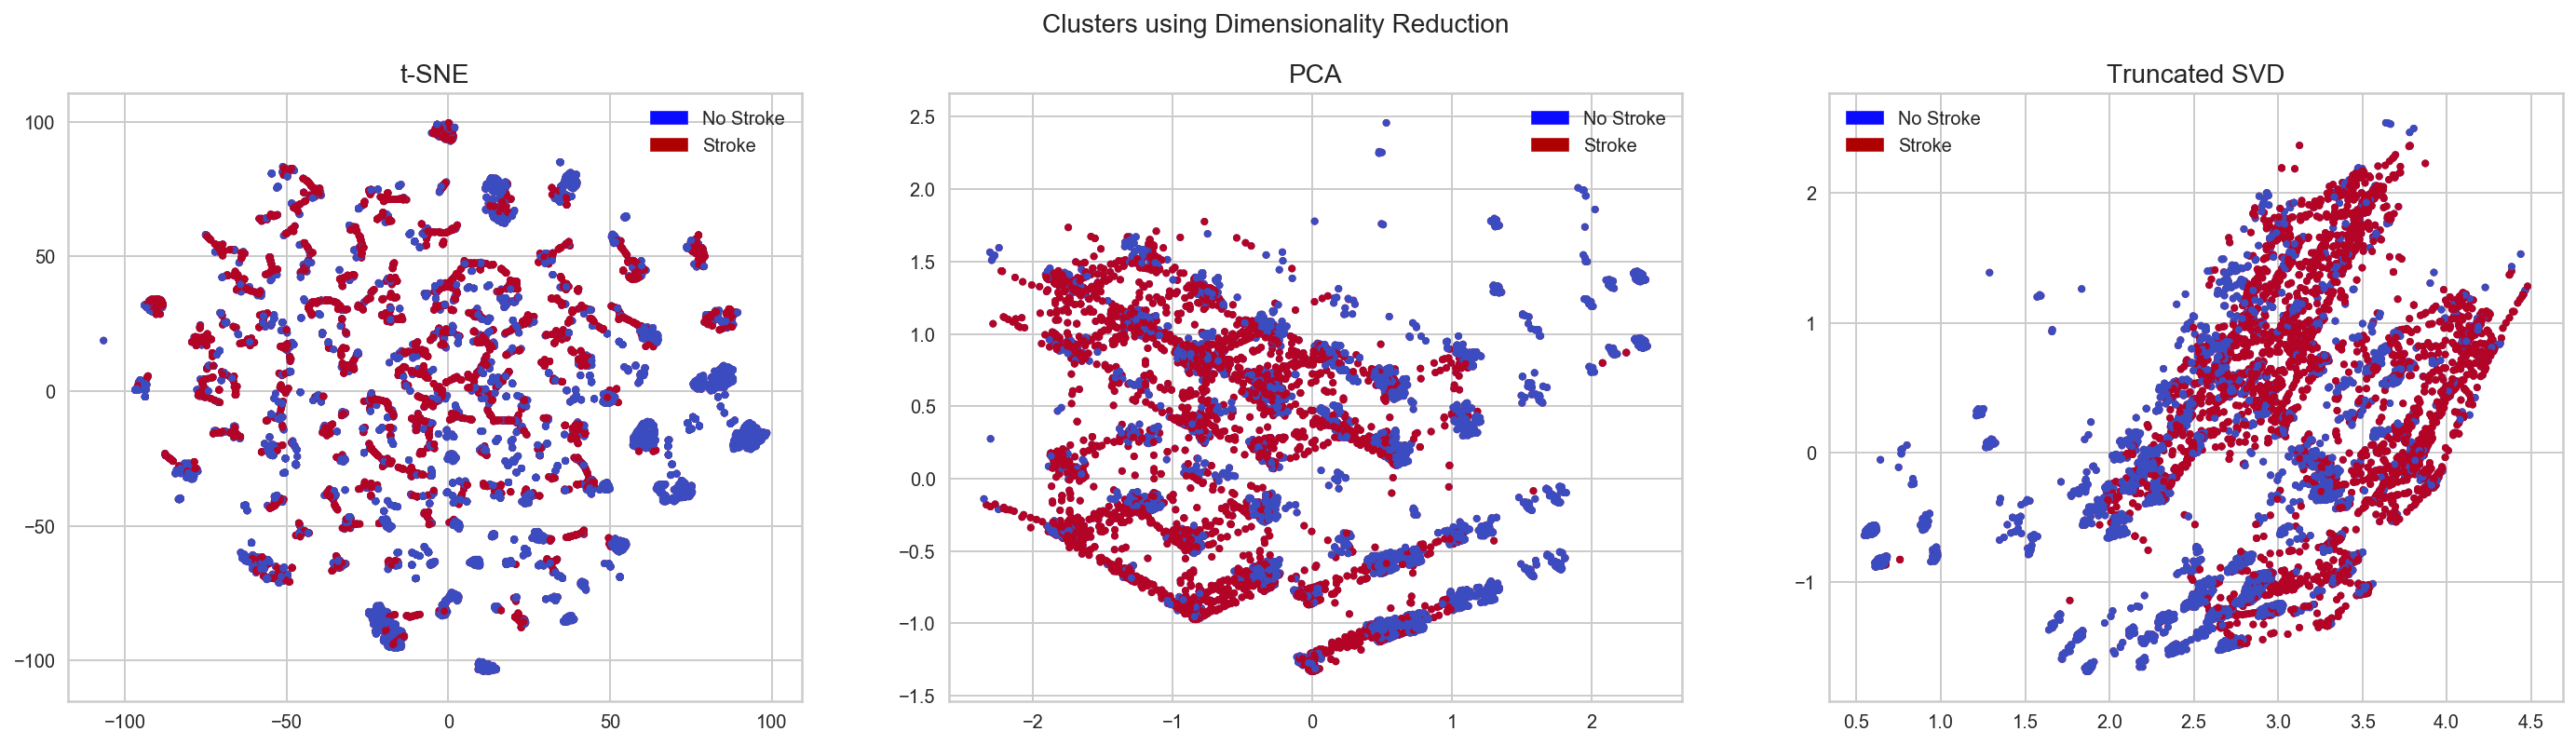

In [73]:
from imblearn.combine import SMOTETomek
stomek = SMOTETomek (random_state=0)
x_stomek, y_stomek = stomek.fit_sample(x_train, y_train)

x_stomek_plot,y_stomek_plot=resample(x_stomek,y_stomek,n_samples=10000,random_state=0)
plot_dim(x_stomek_plot,y_stomek_plot)

C:\Users\syami\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



*Classification Report:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 
               precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      8523
         1.0       0.05      0.07      0.06       157

    accuracy                           0.96      8680
   macro avg       0.52      0.52      0.52      8680
weighted avg       0.97      0.96      0.96      8680


*Classification Report:
 BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=

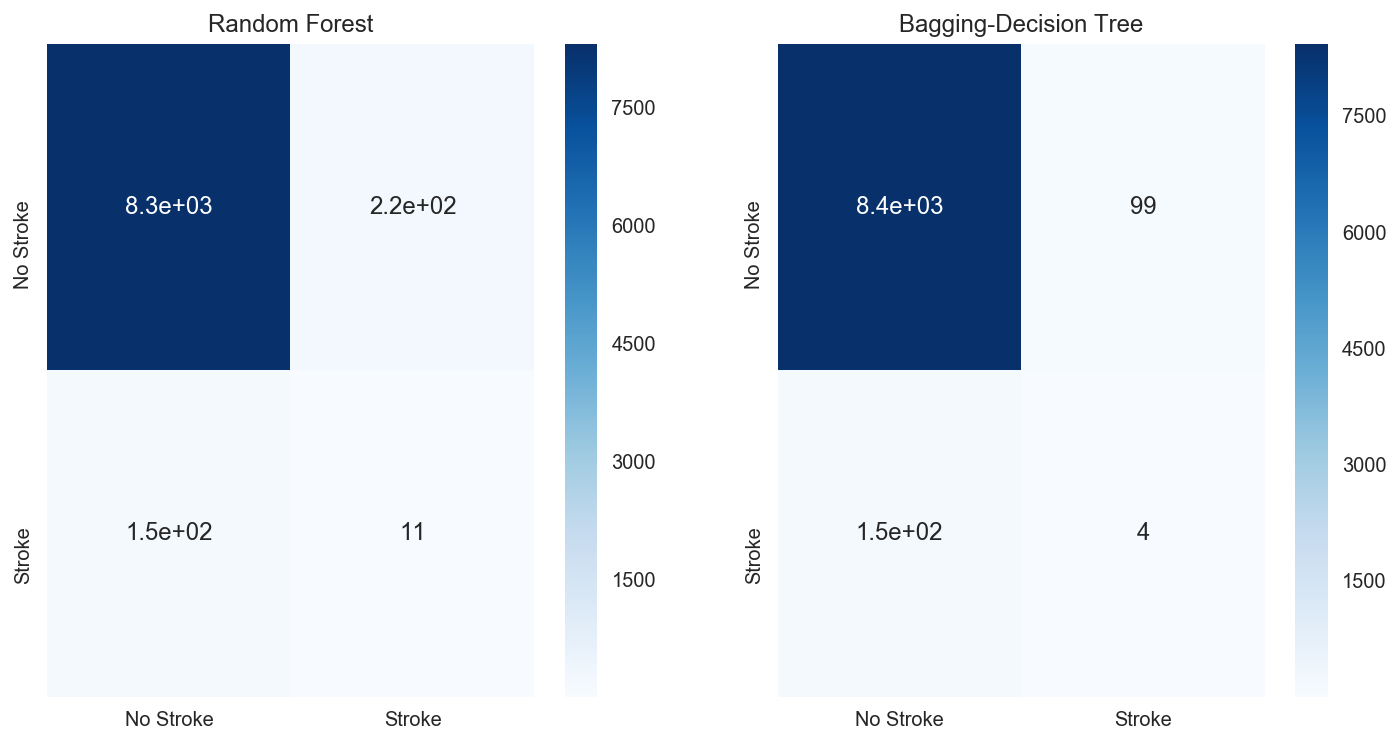

In [74]:
fit_model(x_stomek,x_test,y_stomek,y_test)

#### <font color = blue>Ensemble blancing: Balanced Bagging Classifier.<font>

In [75]:
bbc = BalancedBaggingClassifier (base_estimator=DecisionTreeClassifier(), \
                                 sampling_strategy='not majority',replacement=False,random_state=0)
bbc.fit(x_train, y_train)
bbc.score(x_test, y_test)

0.9808755760368664

Text(0.5,1,'2-class Precision-Recall curve: AP=0.04')

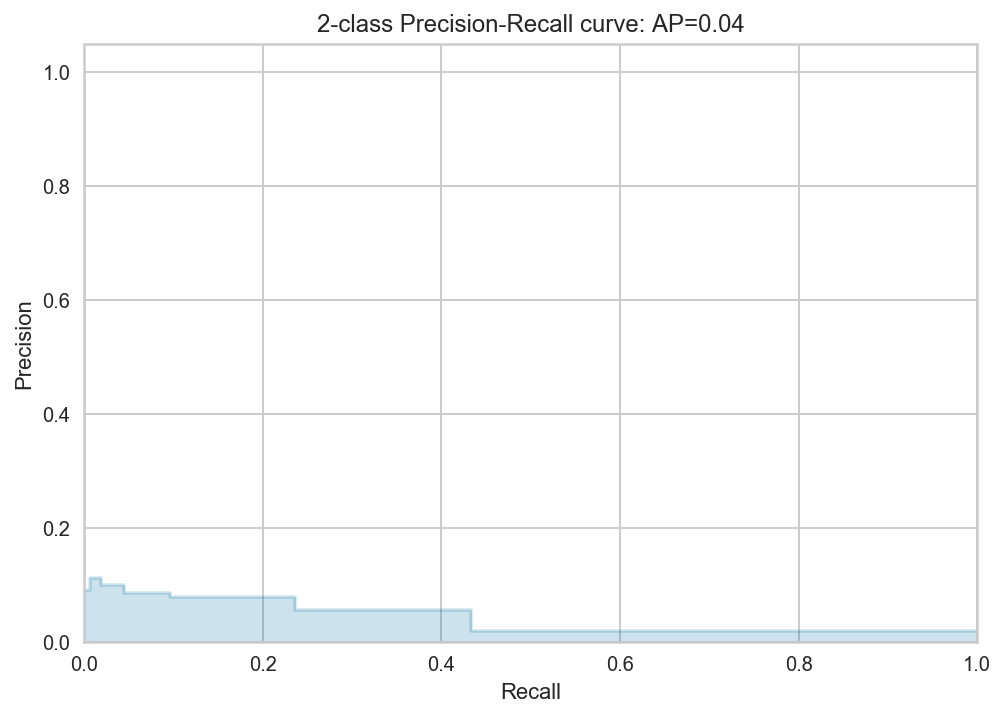

In [76]:
# Precision-Recall Curve
from inspect import signature
from sklearn.metrics import average_precision_score

y_pred_proba = bbc.predict_proba(x_test)[::,1]
average_precision = average_precision_score(y_test, y_pred_proba)

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [87]:
bbsvm=BalancedBaggingClassifier(base_estimator=SVC(C = 27.7, class_weight = {0: 0.5, 1:27.7}),n_estimators=50,\
                                random_state=0, n_jobs=3, sampling_strategy='not majority')
bbsvm.fit(x_train, y_train)

BalancedBaggingClassifier(base_estimator=SVC(C=27.7, cache_size=200,
                                             class_weight={0: 0.5, 1: 27.7},
                                             coef0=0.0,
                                             decision_function_shape='ovr',
                                             degree=3, gamma='auto_deprecated',
                                             kernel='rbf', max_iter=-1,
                                             probability=False,
                                             random_state=None, shrinking=True,
                                             tol=0.001, verbose=False),
                          bootstrap=True, bootstrap_features=False,
                          max_features=1.0, max_samples=1.0, n_estimators=50,
                          n_jobs=3, oob_score=False, random_state=0, ratio=None,
                          replacement=False, sampling_strategy='not majority',
                          verbose=0, warm_start=

Text(0.5,1,'Balanced Bagging - SVM')

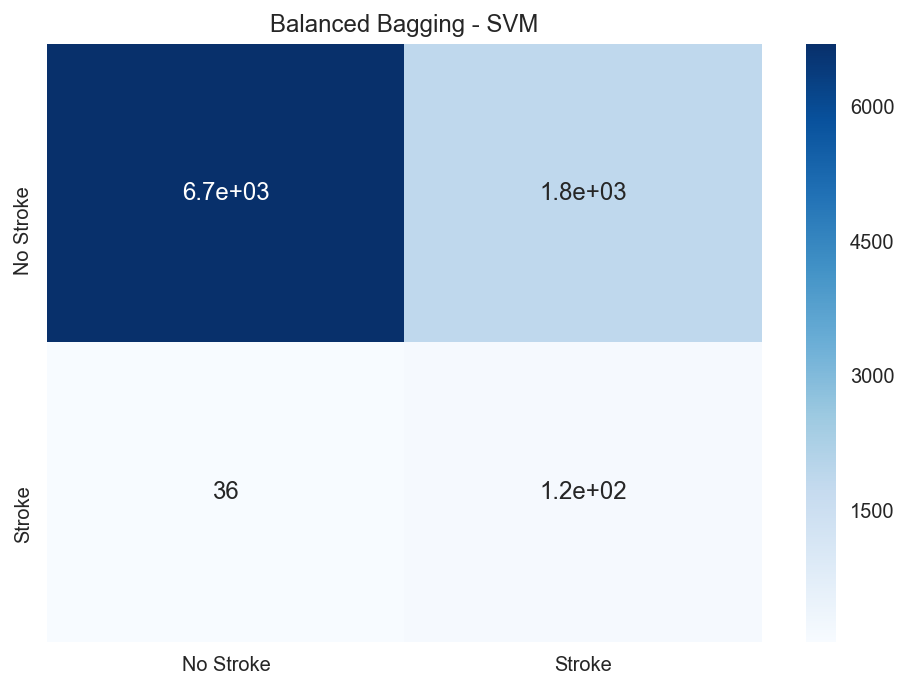

In [88]:
y_pred=bbsvm.predict(x_test)
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True,
                    cmap=plt.cm.Blues,
                   xticklabels=['No Stroke', 'Stroke'],
                   yticklabels=['No Stroke', 'Stroke']).set_title('Balanced Bagging - SVM')

In [89]:
print('Classification report:\n', classification_report(y_test,bbsvm.predict(x_test)), '\n')

Classification report:
               precision    recall  f1-score   support

         0.0       0.99      0.78      0.88      8523
         1.0       0.06      0.77      0.11       157

    accuracy                           0.78      8680
   macro avg       0.53      0.78      0.50      8680
weighted avg       0.98      0.78      0.86      8680
 



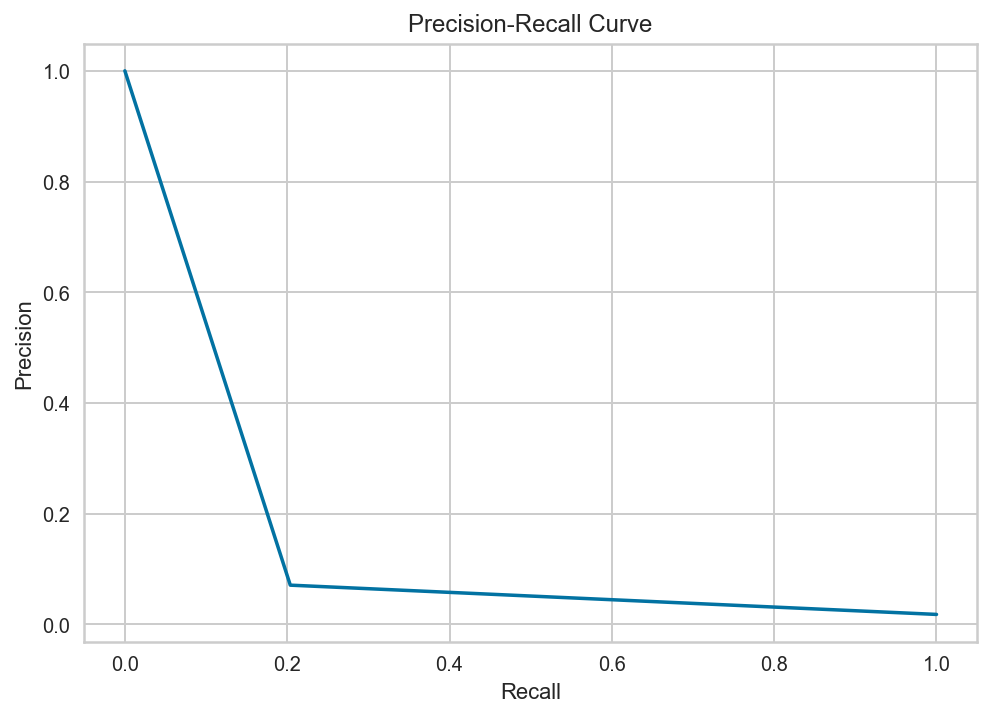

In [85]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision)
plt.title ('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

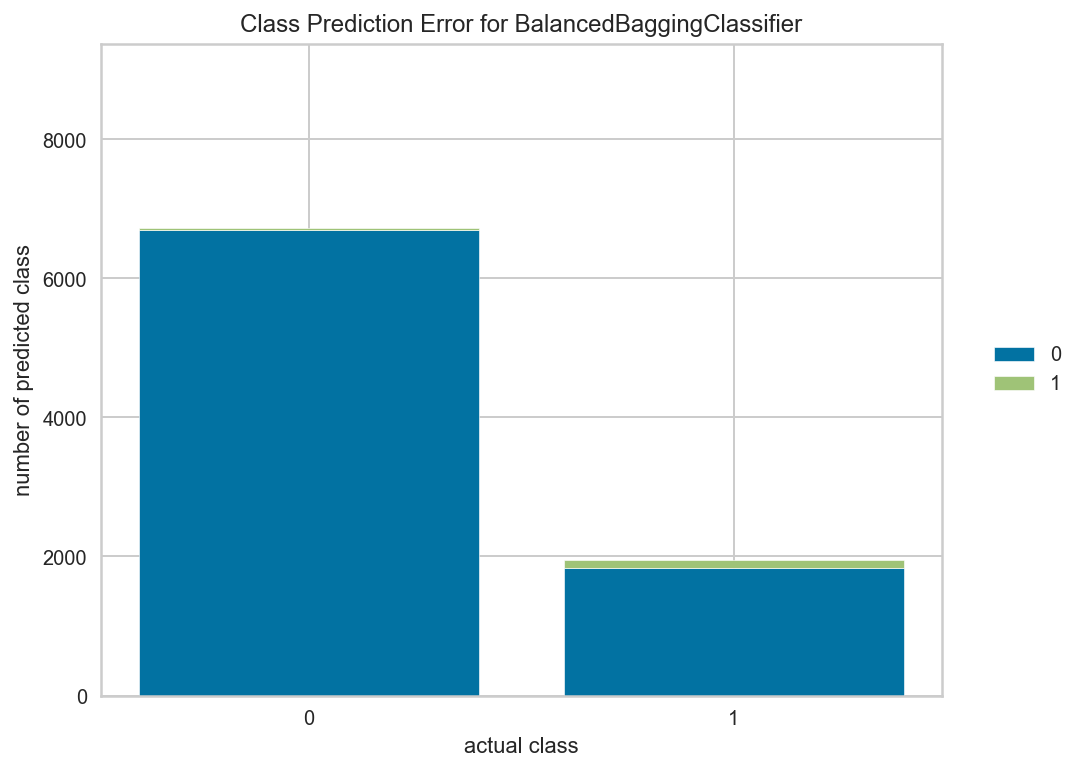

In [81]:
visualizer = ClassPredictionError(
    BalancedBaggingClassifier(base_estimator=SVC(C = 27.7, class_weight = {0: 0.5, 1:27.7}),n_estimators=50,\
                                random_state=0, n_jobs=3, sampling_strategy='not majority'), classes=['0', '1']
)
# Fit the training data to the visualizer
visualizer.fit(x_train, y_train)

# Evaluate the model on the test data
visualizer.score(x_test, y_test)

# Draw visualization
g = visualizer.poof()

In [80]:
# ran = RandomForestClassifier(n_estimators=50, random_state=0, class_weight = 'balanced')
# ran.fit(X_train,y_train)

# pred = ran.predict(X_test)
# print(classification_report(y_test,pred))
# print (accuracy_score(y_test,pred))
# print (confusion_matrix(y_test,pred))

# precision = precision_score(y_test,pred)
# recall = recall_score(y_test,pred)
# print( 'precision = ', precision, '\n', 'recall = ', recall)

# # ROC_AUC Curve
# y_pred_proba = ran.predict_proba(X_test)[::,1]
# fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
# auc = roc_auc_score(y_test, y_pred_proba)
# plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
# plt.legend(loc=4)
# plt.show()

# # Precision-Recall Curve
# from inspect import signature
# from sklearn.metrics import average_precision_score
# average_precision = average_precision_score(y_test, y_pred_proba)

# precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
# # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
# step_kwargs = ({'step': 'post'}
#                if 'step' in signature(plt.fill_between).parameters
#                else {})
# plt.step(recall, precision, color='b', alpha=0.2,
#          where='post')
# plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))


# impFeatures = pd.DataFrame((ran.feature_importances_) ,index=X_train.columns,columns=['Importance']).sort_values(by='Importance',ascending=False)
# print (impFeatures)

NameError: name 'X_train' is not defined

In [ ]:
# ran = RandomForestClassifier(n_estimators=50, random_state=0, class_weight = {0: 1, 1: 100}, max_depth = 4)
# ran.fit(X_train,y_train)

# pred = ran.predict(X_test)
# print('Classification report:\n', classification_report(y_test,pred), '\n')
# print ('-----------------------------')
# print ('Acuracy score:\n', accuracy_score(y_test,pred))
# print ('Confusion matrix:\n', confusion_matrix(y_test,pred))

# precision = precision_score(y_test,pred)
# recall = recall_score(y_test,pred)
# print( 'precision = ', precision, '\n', 'recall = ', recall)

# # ROC_AUC Curve
# y_pred_proba = ran.predict_proba(X_test)[::,1]
# fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
# auc = roc_auc_score(y_test, y_pred_proba)
# plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
# plt.legend(loc=4)
# plt.show()

# # Precision-Recall Curve
# from inspect import signature
# from sklearn.metrics import average_precision_score
# average_precision = average_precision_score(y_test, y_pred_proba)

# precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
# # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
# step_kwargs = ({'step': 'post'}
#                if 'step' in signature(plt.fill_between).parameters
#                else {})
# plt.step(recall, precision, color='b', alpha=0.2,
#          where='post')
# plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))


# impFeatures = pd.DataFrame((ran.feature_importances_) ,index=X_train.columns,columns=['Importance']).sort_values(by='Importance',ascending=False)
# print (impFeatures)

In [ ]:
from xgboost import XGBClassifier
weights = (y == 0).sum() / (1.0 * (y == 1)).sum()
model = XGBClassifier(scale_pos_weight = weights, learning_rate =0.1, n_estimators=1000,
    max_depth=5, min_child_weight=1, gamma=0,subsample=0.8,colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4,seed=27)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [ ]:
print ('\n*Classification Report:\n', classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True, cmap = 'YlGn')
plt.show()

In [ ]:
from sklearn.svm import LinearSVC

def learning_curve(X, y, observations=range(1, 60)):
    scores = []
    for n in observations:
        rus = RandomUnderSampler(random_state=0, ratio={0: n, 1: n})
        rus.fit(X, y)
        X_resampled, y_resampled = rus.fit_sample(X, y)
        score = LinearSVC(max_iter = 10000).fit(X_resampled, y_resampled).score(X, y)
        scores.append(score)
    return scores

plt.plot(range(1, 60), learning_curve(X_train, y_train), linewidth=4)
plt.title("RandomUnderSampler Learning Curve", fontsize=16)
plt.gca().set_xlabel("# of Points per Class", fontsize=14)
plt.gca().set_ylabel("Training Accuracy", fontsize=14)
sns.despine()
pass

#### <font color = blue>Train-test split, SMOTE, cross val, Xgboost<font>

In [ ]:
param_test1 = {'max_depth':range(3,10,2),'min_child_weight':range(1,6,2)}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=1,iid=False, cv=5)
gsearch1.fit(Xsm_train,ysm_train)
print (gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_)

In [ ]:
response, _  = pd.factorize(y)

In [ ]:
def get_enhanced_confusion_matrix(actuals, predictions, labels):
    """"enhances confusion_matrix by adding sensivity and specificity metrics"""
    cm = confusion_matrix(actuals, predictions, labels = labels)
    sensitivity = float(cm[1][1]) / float(cm[1][0]+cm[1][1])
    specificity = float(cm[0][0]) / float(cm[0][0]+cm[0][1])
    weightedAccuracy = (sensitivity * 0.9) + (specificity * 0.1)
    return cm, sensitivity, specificity, weightedAccuracy

xTrain, xTest, yTrain, yTest = train_test_split(scaled_features, response, test_size = .25, random_state = 36583)
print ("building the first forest")

kf = KFold (n_splits = 10)
rf = RandomForestClassifier(n_estimators = 500, min_samples_split = 2, n_jobs = -1, verbose = 1, class_weight = dict({0:0.5, 1:22.3}))
cv_score = cross_val_score(rf, xTrain, yTrain, cv = kf)
rf.fit(xTrain, yTrain)

importances = pd.DataFrame({'name':scaled_features.columns,'imp':rf.feature_importances_
                                }).reset_index(drop = True)

cm, sensitivity, specificity, weightedAccuracy = get_enhanced_confusion_matrix(yTest, rf.predict(xTest), [0,1])
numFeatures = len(scaled_features.columns)

rfeMatrix = pd.DataFrame({'numFeatures':[numFeatures], 
                              'weightedAccuracy':[weightedAccuracy], 
                              'sensitivity':[sensitivity], 
                              'specificity':[specificity]})

print ("running RFE on  %d features"%numFeatures)

for i in range(1,numFeatures,1):
    varsUsed = importances['name'][0:i]
    print ("now using %d of %s features"%(len(varsUsed), numFeatures))
    xTrain, xTest, yTrain, yTest = train_test_split(scaled_features[varsUsed], response, test_size = .25)
    rf = RandomForestClassifier(n_estimators = 500, min_samples_split = 2,
                                n_jobs = -1, verbose = 1, class_weight = dict({0:0.5, 1:22.3}))
    rf.fit(xTrain, yTrain)
    cm, sensitivity, specificity, weightedAccuracy = get_enhanced_confusion_matrix(yTest, rf.predict(xTest), [0,1])
    print("\n"+str(cm))
    print('the sensitivity is %d percent'%(sensitivity * 100))
    print('the specificity is %d percent'%(specificity * 100))
    print('the weighted accuracy is %d percent'%(weightedAccuracy * 100))
    rfeMatrix = rfeMatrix.append(
                                pd.DataFrame({'numFeatures':[len(varsUsed)], 
                                'weightedAccuracy':[weightedAccuracy], 
                                'sensitivity':[sensitivity], 
                                'specificity':[specificity]}), ignore_index = True)    
print("\n"+str(rfeMatrix))    
maxAccuracy = rfeMatrix.weightedAccuracy.max()
maxAccuracyFeatures = min(rfeMatrix.numFeatures[rfeMatrix.weightedAccuracy == maxAccuracy])
featuresUsed = importances['name'][0:maxAccuracyFeatures].tolist()

print ("the final features used are %s"%featuresUsed)

In [ ]:
class Create_ensemble(object):
    def __init__(self, n_splits, base_models):
        self.n_splits = n_splits
        self.base_models = base_models

    def predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)
        no_class = len(np.unique(y))

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, 
                                     random_state = random_state).split(X, y))

        train_proba = np.zeros((X.shape[0], no_class))
        test_proba = np.zeros((T.shape[0], no_class))
        
        train_pred = np.zeros((X.shape[0], len(self.base_models)))
        test_pred = np.zeros((T.shape[0], len(self.base_models)* self.n_splits))
        f1_scores = np.zeros((len(self.base_models), self.n_splits))
        recall_scores = np.zeros((len(self.base_models), self.n_splits))
        
        test_col = 0
        for i, clf in enumerate(self.base_models):
            
            for j, (train_idx, valid_idx) in enumerate(folds):
                
                X_train = X[train_idx]
                Y_train = y[train_idx]
                X_valid = X[valid_idx]
                Y_valid = y[valid_idx]
                
                clf.fit(X_train, Y_train)
                
                valid_pred = clf.predict(X_valid)
                recall  = recall_score(Y_valid, valid_pred, average='macro')
                f1 = f1_score(Y_valid, valid_pred, average='macro')
                
                recall_scores[i][j] = recall
                f1_scores[i][j] = f1
                
                train_pred[valid_idx, i] = valid_pred
                test_pred[:, test_col] = clf.predict(T)
                test_col += 1
                
                ## Probabilities
                valid_proba = clf.predict_proba(X_valid)
                train_proba[valid_idx, :] = valid_proba
                test_proba  += clf.predict_proba(T)
                
                print( "Model- {} and CV- {} recall: {}, f1_score: {}".format(i, j, recall, f1))
                
            test_proba /= self.n_splits
            
        return train_proba, test_proba, train_pred, test_pred

In [ ]:
import warnings
# Define random state
random_state = 2018
np.random.seed(random_state)
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
class_weight = dict({0:0.5, 1:27.7})

rdf = RandomForestClassifier(bootstrap=True, class_weight=class_weight, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False,
            random_state=random_state,
            verbose=0, warm_start=False)

In [ ]:
base_models = [rdf]
n_splits = 5
lgb_stack = Create_ensemble(n_splits = n_splits, base_models = base_models)        

X = data_scaled[data_scaled.columns.difference(['id', 'stroke'])]
y = data_scaled['stroke'].values

X_dummy = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split (X_dummy, y, test_size = 0.20, random_state = 20, stratify = y)

In [ ]:

train_proba, test_proba, train_pred, test_pred = lgb_stack.predict(X_train, y_train, X_test)

In [ ]:
print('1. The F-1 score of the model {}\n'.format(f1_score(y_train, train_pred, average='macro')))
print('2. The recall score of the model {}\n'.format(recall_score(y_train, train_pred, average='macro')))

print ('3. \n*Classification Report:\n', classification_report(y_train, train_pred))

cm = confusion_matrix(y_train, train_pred)

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True, cmap = 'YlGn')
plt.show()

#### <font color = blue>Train-test split, AdaSyn, cross val, Linear svc<font>

In [ ]:
from sklearn import svm
clf = svm.SVC(kernel = 'linear', C = 1.0)
kf = KFold (n_splits = 5)
cv_score = cross_val_score(clf, Xada_train, yada_train, cv = kf)
print ('CV scores = ', cv_score)
print ('CV scores error = ', cv_score.std())
print ('Mean CV scores = ', np.mean(cv_score))

In [ ]:
Accuracy = (tn+tp)*100/(tp+tn+fp+fn) 
print("Accuracy {:0.2f}%" .format(Accuracy))

Precision = tp/(tp+fp) 
print("Precision {:0.2f}".format(Precision))

Recall = tp/(tp+fn) 
print("Recall {:0.2f}".format(Recall))

f1 = (2*Precision*Recall)/(Precision + Recall)
print("F1 Score {:0.2f}".format(f1))

Specificity = tn/(tn+fp)
print("Specificity {:0.2f}".format(Specificity))

Sensitivity = tp/(tp+fn)
print("Specificity {:0.2f}".format(Sensitivity))

# Sensitivity (also called the true positive rate, or the recall in some fields) 
# measures the proportion of actual positives which are correctly identified as such 
# (e.g., the percentage of sick people who are correctly identified as having the condition),
# and is complementary to the false negative rate. Sensitivity= true positives/(true positive + false negative)

# Specificity (also called the true negative rate) measures the proportion of negatives
# which are correctly identified as such (e.g., the percentage of healthy people who are
# correctly identified as not having the condition), and is complementary to the false positive rate. 
# Specificity=true negatives/(true negative + false positives)



In [ ]:
y_pred_proba = model.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_pred_proba)
plt.show()

In [ ]:
coefs = pd.DataFrame({'variable':X_train.columns,'coef':list(model.coef_.T),'abs_coef':list(np.abs(model.coef_.T))})

coefs.sort_values('abs_coef', inplace=True, ascending=False)

coefs.head(20)